In [ ]:
!cat /proc/cpuinfo | grep model\ name

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


# Data Analysis Study

This is the source code for Coursework 2 of COMP4030 DMA (DSML), by Yuhao Zhang & Yichen Lu. The dataset used is [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import collections
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install basemap
from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.6/860.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.7 MB/s eta 0:00:00


In [ ]:
# mount google drive
# TODO: delete this while submitting code for CW2
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. Load Dataset

In [ ]:
# load data
df_label = pd.read_csv('/content/gdrive/MyDrive/training_set_labels.csv')
# print(df_label.shape)
df_value = pd.read_csv('/content/gdrive/MyDrive/training_set_values.csv')
# print(df_value.shape)
# print(df_value.head())
df = pd.merge(df_label, df_value, how='inner')
print(df.shape)
df.head()

(59400, 41)


id    status_group  amount_tsh date_recorded        funder  gps_height     installer  longitude   latitude              wpt_name  num_private                    basin  subvillage   region  region_code  district_code        lga        ward  population public_meeting              recorded_by scheme_management                  scheme_name permit  construction_year extraction_type extraction_type_group extraction_type_class management management_group         payment payment_type water_quality quality_group      quantity quantity_group                source           source_type source_class              waterpoint_type waterpoint_type_group
0  69572      functional      6000.0    2011-03-14         Roman        1390         Roman  34.938093  -9.856322                  none            0               Lake Nyasa    Mnyusi B   Iringa           11              5     Ludewa    Mundindi         109           True  GeoData Consultants Ltd               VWC                        Roman  False               1999         gravity               gravity               gravity        vwc       user-group    pay annually     annually          soft          good        enough         enough                spring                spring  groundwater           communal standpipe    communal standpipe
1   8776      functional         0.0    2013-03-06       Grumeti        1399       GRUMETI  34.698766  -2.147466              Zahanati            0            Lake Victoria     Nyamara     Mara           20              2  Serengeti       Natta         280            NaN  GeoData Consultants Ltd             Other                          NaN   True               2010         gravity               gravity               gravity        wug       user-group       never pay    never pay          soft          good  insufficient   insufficient  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe
2  34310      functional        25.0    2013-02-25  Lottery Club         686  World vision  37.460664  -3.821329           Kwa Mahundi            0                  Pangani     Majengo  Manyara           21              4  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd               VWC  Nyumba ya mungu pipe scheme   True               2009         gravity               gravity               gravity        vwc       user-group  pay per bucket   per bucket          soft          good        enough         enough                   dam                   dam      surface  communal standpipe multiple    communal standpipe
3  67743  non functional         0.0    2013-01-28        Unicef         263        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd               VWC                          NaN   True               1986     submersible           submersible           submersible        vwc       user-group       never pay    never pay          soft          good           dry            dry           machine dbh              borehole  groundwater  communal standpipe multiple    communal standpipe
4  19728      functional         0.0    2011-07-13   Action In A           0       Artisan  31.130847  -1.825359               Shuleni            0            Lake Victoria  Kyanyamisa   Kagera           18              1    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd               NaN                          NaN   True                  0         gravity               gravity               gravity      other            other       never pay    never pay          soft          good      seasonal       seasonal  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe

In [ ]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

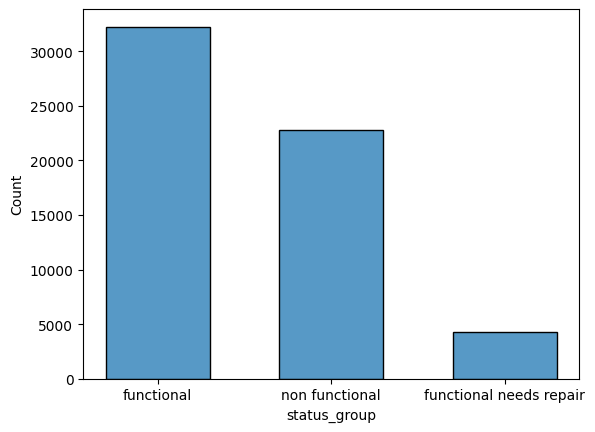

In [ ]:
sns.histplot(data=df, x='status_group', shrink=0.6)
plt.show()

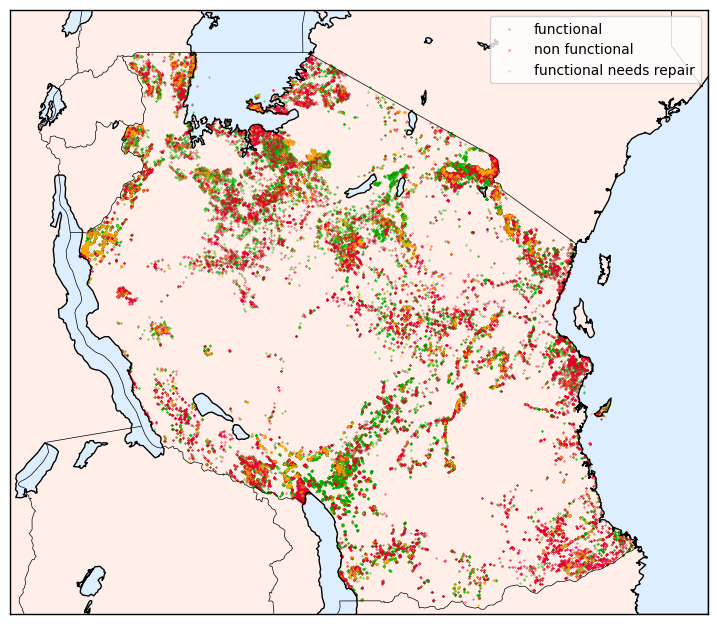

In [ ]:
xs = [0,0,0]
ys = [0,0,0]
cs = ['functional', 'non functional', 'functional needs repair']
colors = ['#00B000', '#E9002D', '#FFAA00']
for i in range(3):
  xs[i] = df.loc[df['status_group'] == cs[i], 'longitude']
  ys[i] = df.loc[df['status_group'] == cs[i], 'latitude']

plt.figure(figsize=(9,9))
m = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i')
m.fillcontinents(color="#FFEFE8", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()
for i in range(3):
  m.scatter(xs[i], ys[i], s=0.1, latlon=True, c=colors[i], label=cs[i])
plt.legend()
plt.show()

## 2. Data Wrangling and Pre-processing

### 2.1 Explore the dataset

#### 2.1.1 Datatype of attributes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

[Conclusion] By observation, we can see that all the datatype of all attributes match the actual data type in the dataset. Therefore, there is no need to use `.astype()` to correct datatype of attributes for this dataset.

#### 2.1.2 Find potential problems - numerical attributes

In [ ]:
df.describe()

id     amount_tsh    gps_height     longitude      latitude   num_private   region_code  district_code    population  construction_year
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04  59400.000000  59400.000000   59400.000000  59400.000000       59400.000000
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00      0.474141     15.297003       5.629747    179.909983        1300.652475
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00     12.236230     17.587406       9.633649    471.482176         951.620547
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01      0.000000      1.000000       0.000000      0.000000           0.000000
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00      0.000000      5.000000       2.000000      0.000000           0.000000
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00      0.000000     12.000000       3.000000     25.000000        1986.000000
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00      0.000000     17.000000       5.000000    215.000000        2004.000000
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   1776.000000     99.000000      80.000000  30500.000000        2013.000000

In [ ]:
df['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2428, dtype: int64

In [ ]:
df['longitude'].value_counts()

0.000000     1812
37.375717       2
38.340501       2
39.086183       2
33.005032       2
             ... 
35.885754       1
36.626541       1
37.333530       1
38.970078       1
38.104048       1
Name: longitude, Length: 57516, dtype: int64

In [ ]:
df['latitude'].value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-6.980220e+00       2
-2.476680e+00       2
-6.978263e+00       2
                 ... 
-3.287619e+00       1
-8.234989e+00       1
-3.268579e+00       1
-1.146053e+01       1
-6.747464e+00       1
Name: latitude, Length: 57517, dtype: int64

In [ ]:
df['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [ ]:
df['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [ ]:
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: population, Length: 1049, dtype: int64

In [ ]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

[Conclusion] By observing the statistics of **numerical attributes** we can find statistics of these attributes, that some need data wrangling / cleaning:

- `amount_tsh`: over 50% of the records have values of `0`, and the max value is too large
 - suggestion: might drop the attribute

- `num_private`: over 75% of the records have values of `0`
 - suggestion: might drop the attribute

- `region_code`, `district_code`: it seems to be a unique id, but the unique id seems not to be consecutive
 - suggestion: might deal it as a label, i.e. Nominal data, not Ordinal / Interval / Ratio data

- `gps_height`: 20438 (34.41%) records have values of `0`
 - suggestion: impute by mean of geographic group

- `longtitude` and `latitude`: 1812 (3.05%) pairs of records have values of `(0, -2.000000e-08)`
 - suggestion: impute by mean of geographic group


- `population`: 21381 (35.99%) records have values of `0`
 - suggestion: impute by mean of geographic group

- `construction_year`: 20709 (34.86%) records have values of `0`
 - suggestion: impute by mean of installer group

#### 2.1.3 Find potential problems - categorical attributes

In [ ]:
arr = df['wpt_name'].unique()
arr.sort()
for item in arr:
  print(item, end = '; ')

24; A Kulwa; A Saidi; Abass; Abbas; Abdala Hamisi; Abdala Mwandute; Abdalaa; Abdalah; Abdalah Ali; Abdalah Mashaka; Abdalah Miliki; Abdalah Mwakibona; Abdalah Shombe; Abdalamani Mussa; Abdalla Nambambili; Abdallah Chingi; Abdallah Miwani; Abdallah Mponzi; Abdallah Nassor Msabaha; Abdallah Nassoro; Abdi; Abdieri Serakike; Abdu; Abdul; Abdul Sharif; Abdul Swalehe; Abedi Taliwa; Abel Mgaya; Abel Mwalongo; Abel Nasari; Abel Tewene; Abelrunyagu; Abihudi; Abisalum Mose; Abiudi Nyarandu; Abiya; Ablahaman; Abobo; Abraham; Abraham Nlemi; Abraham Sichula; Absalim2 Mose; Abubakari Pajero 1; Abubakari Pajero 2; Abunwasi Mwanguti; Adalus; Adam; Adam Jee; Adam Mgumba; Adam Muhameid; Adam Mwajanjela; Adam Ramadhan; Adam Rashid; Adam Shitindi; Adam Sigara; Adam Simba; Adamu; Adamu Juma; Adel Palanjo; Adelina Nziku; Adiyeli; Adonatu; Adp Office; Adrea; Adrea Mabande; Adrew; Adrew Chambo; Adson Ibrahim Mbise; Adson Vumba; Adventist Church; Afitwa; Afrael Kaaya; Afrael Palanjo; Afraeli; Afred; Africa; Af

In [ ]:
print(df[df['wpt_name'] == 'none'].shape[0])
print(df[df['wpt_name'] == 'None'].shape[0])

3563
2


In [ ]:
arr = df['scheme_name'].unique()
for item in arr:
  print(item, end = '; ')

Roman; nan; Nyumba ya mungu pipe scheme; Zingibali; BL Bondeni; None; wanging'ombe water supply s; Makanj; Kidabu; Mashangwi; Quick wins Program; Komaka mandaka; Sobodo Borehole Scheme; Kitukuni water supply; BL Mwakikoti; Chalinze wate; Mae pipeline; UNDP; Ngana water supplied scheme; Itun; Bomala; Kirua kahe pumping water trust; Misiwa; Mtwango water supplied sche; K; Machumba estate pipe line; SHIMASA; wangama water supply scheme; Shirimatunda Water Supply; Laela group water Supp; Makwale water supplied sche; Nyang'hwale; Njoro Water Supply; Kirua kahe gravity water supply trust; Olgilai pipe line; Mabula mountains spr; Mkongoro One; Maambreni gravity water supply; Mwando water supply; M; Kaisho/Isingiro w; wanging'ombe supply scheme; Tove Mtwango gravity Scheme; Tengeru gravity water supply; Kulasi water supply; Malemb; Tawa; Loruvani gravity water supply; HESAWA; B; Gawa; Chankele/Bubango water project; Bagamoyo wate; Kijiji; Donge; Mradi wa maji wa mpitimbi; Mwang'hosha Nyamalogo

In [ ]:
print(df[df['scheme_name'] == 'none'].shape[0])
print(df[df['scheme_name'] == 'None'].shape[0])
print(df['scheme_name'].isnull().sum())

25
644
28166


In [ ]:
arr = df['installer'].unique()
for item in arr:
  print(item, end = '; ')

Roman; GRUMETI; World vision; UNICEF; Artisan; DWE; DWSP; Water Aid; Private; DANIDA; Lawatefuka water sup; WEDECO; Danid; TWE; ISF; Kilolo Star; District council; Water; WU; nan; Not known; Central government; CEFA; Commu; Accra; World Vision; LGA; MUWSA; KKKT _ Konde and DWE; Government; Olgilai village community; KKKT; RWE; Adra /Community; SEMA; SHIPO; HESAWA; ACRA; Community; IFAD; Sengerema Water Department; HE; ISF and TACARE; Kokeni; DA; Adra; ALLYS; AICT; KIUMA; CES; District Counci; Ruthe; Adra/Community; Tulawaka Gold Mine; KKT C; Hesawa; Water board; LOCAL CONTRACT; WFP; LIPS; TASAF; World; 0; SW; Shipo; Fini water; Kanisa; OXFARM; VILLAGE COUNCIL Orpha; Villagers; Idara ya maji; FPCT; WVT; Ir; DANID; Angli; secondary school; Amref; JBG; DADIS; International Aid Services; RW; Dmdd; TCRS; RC Church; WATER AID; JICA; Gwasco L; AF; AMREF; wananchi; FW; Central Government; MWE &; Gove; RC CHURCH; TDFT; RWE/DWE; Central govt; World Bank; TWESA; Norad; Hans; FinW; FIN WATER; OXFA

In [ ]:
print(df[df['installer'] == '0'].shape[0])
print(df[df['installer'] == ''].shape[0])
print(df['installer'].isnull().sum())

777
0
3655


In [ ]:
arr = df['funder'].unique()
for item in arr:
  print(item, end = '; ')

Roman; Grumeti; Lottery Club; Unicef; Action In A; Mkinga Distric Coun; Dwsp; Rwssp; Wateraid; Isingiro Ho; Private; Danida; World Vision; Lawatefuka Water Supply; Biore; Rudep; Hesawa; Twe; Isf; African Development Bank; Government Of Tanzania; Sobodo; Water; Private Individual; Undp; nan; Not Known; Kirde; Cefa; Ces(gmbh); European Union; Lga; District Council; Muwsa; Dwe/norad; Kkkt_makwale; Sawaka; Ces (gmbh); Olgilai Village Community; Kkkt; Roman Catholic; Norad; Adra; Sema; Piusi; Dwe; Rc Church; Swisland/ Mount Meru Flowers; Ifad; Swedish; Idc; He; Isf/tacare; Jica; Mzee Sh; Aict; Tcrs; Kiuma; Germany Republi; Netherlands; Ruthe; Tulawaka Gold Mine; Nethalan; Tasaf; Concern World Wide; Wfp; Lips; Sida; World Bank; Tanza; 0; Sw; Shipo; Fini Water; Kanisa; Oxfarm; Village Council; Hesawz; Shanta; Fpct; Wvt; Dhv; Ir; Oikos E.Afrika; Anglican Church; Peters; Donor; Secondary Schoo; Amref; Ministry Of Water; Adb; Jbg; Dadis; International Aid Services; Germany; Kibaha Town Council; 

In [ ]:
print(df[df['funder'] == 'Not Known'].shape[0])
print(df[df['funder'] == 'None'].shape[0])
print(df[df['funder'] == '0'].shape[0])
print(df['funder'].isnull().sum())

27
2
777
3635


By ovserving values of attributes `wpt_name`, `scheme_name`, `installer` and `funder`, we can find that missing values can be in the form of `[empty]`, `none`, `None`, `Not Known`, `0`, or `NaN`. Based on the findings, we try to count the number of missing values for all categorical attributes.

In [ ]:
ls_categorical = ['status_group', 'date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 
          'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class',
          'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 
          'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

print('number of missing values in categorical attributes')
for attr in ls_categorical:
  print(attr, end=': ')
  print(df[df[attr] == ''].shape[0] + df[df[attr] == 'none'].shape[0] + df[df[attr] == 'None'].shape[0] + df[df[attr] == '0'].shape[0] + df[df[attr] == 'Not Known'].shape[0] + df[attr].isnull().sum())

number of missing values in categorical attributes
status_group: 0
date_recorded: 0
funder: 4441
installer: 4432
wpt_name: 3585
basin: 0
subvillage: 371
region: 0
lga: 0
ward: 0
public_meeting: 3334
recorded_by: 0
scheme_management: 3878
scheme_name: 28835
permit: 3056
extraction_type: 0
extraction_type_group: 0
extraction_type_class: 0
management: 0
management_group: 0
payment: 0
payment_type: 0
water_quality: 0
quality_group: 0
quantity: 0
quantity_group: 0
source: 0
source_type: 0
source_class: 0
waterpoint_type: 0
waterpoint_type_group: 0


In [ ]:
ls_categorical = ['status_group', 'date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 
          'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class',
          'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 
          'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

print('number of categories')
for attr in ls_categorical:
  print(attr, end=': ')
  print(len(df[attr].unique()))

number of categories
status_group: 3
date_recorded: 356
funder: 1898
installer: 2146
wpt_name: 37400
basin: 9
subvillage: 19288
region: 21
lga: 125
ward: 2092
public_meeting: 3
recorded_by: 1
scheme_management: 13
scheme_name: 2697
permit: 3
extraction_type: 18
extraction_type_group: 13
extraction_type_class: 7
management: 12
management_group: 5
payment: 7
payment_type: 7
water_quality: 8
quality_group: 6
quantity: 5
quantity_group: 5
source: 10
source_type: 7
source_class: 3
waterpoint_type: 7
waterpoint_type_group: 6


Here we count number of categories of each categorical attributes. It cames into our sight that `wpt_name` and `subvillage` have too many categories (1.6 records per category, and 3.1 records per category, respectively), which means that it is almost impossible to impute these data and perform machine learning tasks e.g. classification on them. Besides, they have a weak relationship to our research question, i.e. they do not affect the status of the waterpoint.

[Conclusion] By observing the statistics of **categorical attributes** we can find:

- [missing data] missing values are indicated as `[empty]`, `none`, `None`, `Not Known`, `0`, or `NaN`
- [missing data] categorical attribute with missing values: `funder`, `installer`, `wpt_name`, `subvillage`, `public_meeting`, `scheme_management`, `scheme_name`, `permit`
- [missing data] `scheme_name` has too many missing values (28835, 48.5%)
- [fractured data] `wpt_name` and `subvillage` have too many categories, i.e. the granularity is too fine
- [very large number of attributes] `subvillage`, `longitude`, `latitude`, `region`, `region code`, `district code` all indicates the geographical location of waterpoints, and they vary in type of data and granularity.

### 2.2 Drop irrelevant & fractured attributes

We would like to drop the following attributes before doing further work:
- `id`: the unique id for waterpoint is not used in further analysis. We can use the row index as the unique id.
- `wpt_name`, `funder`, `recorded_by`: the name of the water point, the funder, and the person record the data do not affect the status of the waterpoint.
- `num_private`, `amount_tsh`, `scheme_name`: these attributes have too many missing values (over or around 50% of values are missing). Therefore, it is inappropriate to impute these data (by mean value or by other methods ...), and we decide to delete them.
- `region`: `region` (21 categories) and `region_code` (27 categories) serve for very same granularity and represents the same thing, i.e. overlap functionality. Therefore, we can remove one and use another.
- `subvillage`: the granularity is too fine as a categorical attribute. For geographical location of waterpoints, we can refer to `longitude` and `latitude` which is numerical; or we can use `region_code` and `district_code` which is categorical and is much more coarse and acceptable.

In [ ]:
df = df.drop(columns=['id', 'funder', 'num_private', 'amount_tsh', 'scheme_name', 'wpt_name', 'recorded_by', 'subvillage', 'region'])
print(df.shape)
df.head()

(59400, 32)


status_group date_recorded  gps_height     installer  longitude   latitude                    basin  region_code  district_code        lga        ward  population public_meeting scheme_management permit  construction_year extraction_type extraction_type_group extraction_type_class management management_group         payment payment_type water_quality quality_group      quantity quantity_group                source           source_type source_class              waterpoint_type waterpoint_type_group
0      functional    2011-03-14        1390         Roman  34.938093  -9.856322               Lake Nyasa           11              5     Ludewa    Mundindi         109           True               VWC  False               1999         gravity               gravity               gravity        vwc       user-group    pay annually     annually          soft          good        enough         enough                spring                spring  groundwater           communal standpipe    communal standpipe
1      functional    2013-03-06        1399       GRUMETI  34.698766  -2.147466            Lake Victoria           20              2  Serengeti       Natta         280            NaN             Other   True               2010         gravity               gravity               gravity        wug       user-group       never pay    never pay          soft          good  insufficient   insufficient  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe
2      functional    2013-02-25         686  World vision  37.460664  -3.821329                  Pangani           21              4  Simanjiro     Ngorika         250           True               VWC   True               2009         gravity               gravity               gravity        vwc       user-group  pay per bucket   per bucket          soft          good        enough         enough                   dam                   dam      surface  communal standpipe multiple    communal standpipe
3  non functional    2013-01-28         263        UNICEF  38.486161 -11.155298  Ruvuma / Southern Coast           90             63   Nanyumbu    Nanyumbu          58           True               VWC   True               1986     submersible           submersible           submersible        vwc       user-group       never pay    never pay          soft          good           dry            dry           machine dbh              borehole  groundwater  communal standpipe multiple    communal standpipe
4      functional    2011-07-13           0       Artisan  31.130847  -1.825359            Lake Victoria           18              1    Karagwe  Nyakasimbi           0           True               NaN   True                  0         gravity               gravity               gravity      other            other       never pay    never pay          soft          good      seasonal       seasonal  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe

### 2.3 Correcting Syntax Errors and Typos

In [ ]:
ls_categorical_dropped = ['status_group', 'date_recorded', 'installer', 'basin', 'lga', 'ward', 'public_meeting', 
          'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class',
          'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 
          'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

for attr in ls_categorical_dropped:
  arr = df[attr].unique()
  arr2 = list(set([str(item).lower() for item in arr]))
  arr3 = list(set([str(item).replace(' ', '') for item in arr2]))
  arr4 = list(set([str(item).translate(str.maketrans('', '', string.punctuation)) for item in arr3]))
  print(attr.ljust(16) + '\t' + str(len(arr) == len(arr2)) + '\t' + str(len(arr2) == len(arr3)) + '\t' + str(len(arr3) == len(arr4)) + '\t' + str(len(arr4)))

status_group    	True	True	True	3
date_recorded   	True	True	True	356
installer       	False	False	False	1852
basin           	True	True	True	9
lga             	True	True	True	125
ward            	True	False	True	2090
public_meeting  	True	True	True	3
scheme_management	True	True	True	13
permit          	True	True	True	3
extraction_type 	True	True	True	18
extraction_type_group	True	True	True	13
extraction_type_class	True	True	True	7
management      	True	True	True	12
management_group	True	True	True	5
payment         	True	True	True	7
payment_type    	True	True	True	7
water_quality   	True	True	True	8
quality_group   	True	True	True	6
quantity        	True	True	True	5
quantity_group  	True	True	True	5
source          	True	True	True	10
source_type     	True	True	True	7
source_class    	True	True	True	3
waterpoint_type 	True	True	True	7
waterpoint_type_group	True	True	True	6


In [ ]:
arr = df['installer'].unique()
arr2 = [str(item).lower() for item in arr]
print([item for item, count in collections.Counter(arr2).items() if count > 1])

['world vision', 'unicef', 'dwe', 'water aid', 'private', 'wedeco', 'danid', 'district council', 'water', 'not known', 'central government', 'cefa', 'commu', 'lga', 'government', 'kkkt', 'shipo', 'hesawa', 'community', 'sengerema water department', 'da', 'adra', 'water board', 'tasaf', 'world', 'fini water', 'kanisa', 'villagers', 'idara ya maji', 'ir', 'angli', 'secondary school', 'amref', 'dmdd', 'rc church', 'jica', 'af', 'wananchi', 'world bank', 'norad', 'fin water', 'plan int', 'makonde water population', 'is', 'kuwait', 'mw', 'individuals', 'dawasco', 'gover', 'mission', 'consulting engineer', 'marafip', 'world banks', 'local technician', 'village', 'cons', 'district water department', 'wizara ya maji', 'jaica', 'onesm', 'local', 'rc', 'governme', 'do', 'rc ch', 'rotary club', 'care international', 'go', 'maswi company', 'ta', 'wanan', 'region water department', 'wa', 'village council', 'local  technician', 'gtz', 'ch', 'p', 'action contre la faim', 'water aid /sema', 'ncaa', 'm

In [ ]:
for i in range(0, len(arr2)):
  if (arr2[i] == 'world vision'):
    print(arr[i])

World vision
World Vision
WORLD VISION
world vision


In [ ]:
arr = df['installer'].unique()
arr2 = list(set([str(item).lower() for item in arr]))
arr3 = [str(item).replace(' ', '') for item in arr2]
print([item for item, count in collections.Counter(arr3).items() if count > 1])

['dwe', 'villagecouncil', 'halmashauriyamanispatabora', 'dr.matobola', 'janduplumberco', 'naishuconstructionco.ltd', 'qwickwin', 'oikose.africa', 'ministryofwater', 'tcrs/care', 'totallandcare', 'localltechnician', 'grobalresourcealliance', 'tcrs/twesa', 'rwe/community', 'concern/government', 'finwater', 'government/tcrs', 'wateraid', 'mombourbanwater', 'saxonbuildingcontractor', 'mlakico', 'tassaf/tcrs', 'wizarayamaji', 'runduman', 'adra/community', 'twesa/community', 'dr.matomola', 'dwe/tassaf', 'districtcouncil', 'killflora/community', 'mwl.nyereresec.school', 'localtechnician', 'wateraid/sema', 'rcchurch/cefa', 'kiliwater', 'jlhcoltd', 'careinternational', 'singidayetu', 'winamconstruction', 'petcorporationltd', 'nyakilanganico', 'goldstar', 'adra/government', 'tcrs/dwe']


In [ ]:
for i in range(0, len(arr3)):
  if (arr3[i] == 'localtechnician'):
    print(arr2[i])

local  technician
local technician
localtechnician


In [ ]:
arr = df['installer'].unique()
arr2 = list(set([str(item).lower() for item in arr]))
arr3 = list(set([str(item).replace(' ', '') for item in arr2]))
arr4 = [str(item).translate(str.maketrans('', '', string.punctuation)) for item in arr3]
print([item for item, count in collections.Counter(arr4).items() if count > 1])

['dwe', 'rcchurch', 'tasaf', 'magadinimakiwaruwa', 'w', 'o', 'rudep', 'oikoseafrica', 'tcrstwesa', 'wdandid', 'wb', 'tcrstlc', 'rwecommunity', 'dw', 'adb', 'gdid', 'norad', 'handenitrunkmain', 'rc', 'mwe', 'farmafrica', 'maswidrillingcoltd', 'rcmission', 'tanzegypttechnicalcoopera', 'rwedwe', 'wwf', 'romancathoricsame']


In [ ]:
for i in range(0, len(arr4)):
  if (arr4[i] == 'w'):
    print(arr3[i])

w
w/


From the statistics we can find that there are inconsistant syntax in following attributes: `installer`, `ward`:

- differences upper/lowercase: for example, 'World vision', 'World Vision', 'WORLD VISION', 'world vision'
- differences in number of spaces: for example, 'local  technician', 'localtechnician', 'local technician'
- differences in usage of punctuation: for example, 'w', 'w/'

Data in these attributes are uniformed to the form of 'lower case + no spaces + no punctuation'

In [ ]:
df['installer'] = df['installer'].apply(lambda item : str(item).lower().replace(' ', '').translate(str.maketrans('', '', string.punctuation)))
df['ward'] = df['ward'].apply(lambda item : str(item).lower().replace(' ', '').translate(str.maketrans('', '', string.punctuation)))
print(df.shape)
df.head()

(59400, 32)


status_group date_recorded  gps_height    installer  longitude   latitude                    basin  region_code  district_code        lga        ward  population public_meeting scheme_management permit  construction_year extraction_type extraction_type_group extraction_type_class management management_group         payment payment_type water_quality quality_group      quantity quantity_group                source           source_type source_class              waterpoint_type waterpoint_type_group
0      functional    2011-03-14        1390        roman  34.938093  -9.856322               Lake Nyasa           11              5     Ludewa    mundindi         109           True               VWC  False               1999         gravity               gravity               gravity        vwc       user-group    pay annually     annually          soft          good        enough         enough                spring                spring  groundwater           communal standpipe    communal standpipe
1      functional    2013-03-06        1399      grumeti  34.698766  -2.147466            Lake Victoria           20              2  Serengeti       natta         280            NaN             Other   True               2010         gravity               gravity               gravity        wug       user-group       never pay    never pay          soft          good  insufficient   insufficient  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe
2      functional    2013-02-25         686  worldvision  37.460664  -3.821329                  Pangani           21              4  Simanjiro     ngorika         250           True               VWC   True               2009         gravity               gravity               gravity        vwc       user-group  pay per bucket   per bucket          soft          good        enough         enough                   dam                   dam      surface  communal standpipe multiple    communal standpipe
3  non functional    2013-01-28         263       unicef  38.486161 -11.155298  Ruvuma / Southern Coast           90             63   Nanyumbu    nanyumbu          58           True               VWC   True               1986     submersible           submersible           submersible        vwc       user-group       never pay    never pay          soft          good           dry            dry           machine dbh              borehole  groundwater  communal standpipe multiple    communal standpipe
4      functional    2011-07-13           0      artisan  31.130847  -1.825359            Lake Victoria           18              1    Karagwe  nyakasimbi           0           True               NaN   True                  0         gravity               gravity               gravity      other            other       never pay    never pay          soft          good      seasonal       seasonal  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe

In [ ]:
arr = df['installer'].unique()
arr.sort()
for item in arr:
  print(item, end = '; ')

; 0; aar; aartisa; abasia; abd; abdala; abdallahallywazir; abdul; ac; accra; acord; acra; act; actionaid; actioncontrelafaim; activekmk; activemkm; activetankco; activetankcoltd; actmara; ad; adam; adamkea; adammualuaka; adap; adb; adp; adpbusangi; adra; adracommunity; adragovernment; adrs; af; africa; africaaminialama; africaislamicagencytanzania; africam; africamuslim; africamuslimagenc; africandevelopmentfoundation; africanmuslimsage; africanrealiefcommitteofku; africanreflectionsfoundation; africaone; africaoneltd; africare; afrozismail; agrican; ahmad; ai; aic; aicki; aict; aimgold; aixos; alexmoyela; alha; alia; allys; altaicoltd; amadi; amari; amboniplantation; ambrose; ambwenemwaikeke; amec; american; ampcontract; ampcontractor; ampcontracts; amref; angli; anglicachurch; anglican; anglicanchurch; anglicanuganda; anglikan; anglikana; anglikanachurch; angrikana; ansnanimurij; answar; apm; aqal; aquabluesangels; aqual; aquarmandrillers; aquawat; aquawel; aqwamandrilling; ar; arabc

The uniforming greatly reduces the number of categories in these categories that means the same but varies in syntax, especially for attribute `installer`. However, there are still data in `installer` that cannot be uniformed, for instance, abbreviations of installer, with one example might be 'WB' and 'World Bank'. These can only be manually compared pair by pair, and we lack the knowledge of these installers and their abbreviations (e.g. is 'WB' really the abbreviation for 'World Bank'? What is 'AAR' abbreviation for? ...). Therefore, these data are not further preprocessed, and they will be treat as different categories.

### 2.4 Missing data

#### 2.4.1 Find missing data

In [ ]:
missingdata = df.notnull()
for column in missingdata.columns.values.tolist():
    if missingdata[column].value_counts().size == 2:
      print(column, end = '; ')

public_meeting; scheme_management; permit; 

Attributes with missing values indicated as `NaN`: `public_meeting`, `scheme_management`, `permit`

From findings in previous observations (in Section 2.1.2 and 2.1.3) we can see that missing values in the dataset may be in forms other than `NaN`, that are:
- `0` - in numerical attributes `gps_height`, `population`, `construction_year`, `longtitude`, `latitude`
- `[empty]`, `none`, `None`, `Not Known`, `0`, or `nan` - in categorical attributes
 `installer`, `public_meeting`, `scheme_management`, `permit`


[Conclusion] Missing data lies in attributes: `gps_height`, `population`, `construction_year`, `longtitude`, `latitude`, `installer`, `public_meeting`, `scheme_management`, `permit`

Following Sections will deal with each attributes containing missing values respectively.

#### 2.4.2 `longitude` and `latitude` - impute by average value of the subgroup with the same `region_code` and `district_code`

Referring to The administrative divisions of Tanzania, the country is divided into regions and each region is subdivided into districts. Therefore, `region_code` and `district_code` are combined into `position_code`. As these codes both consists of 1-2 digits, the `position_code` is designed to have the format `XX[region code]000XX[district code]`.

In [ ]:
df0 = df.copy()
column_after = 'district_code'
insert_position = df0.columns.get_loc(column_after) + 1
df0.insert(loc=insert_position, column='position_code', value=0)
df0['position_code'] = df0['region_code']*100000 + df0['district_code']
df0['position_code']

0        1100005
1        2000002
2        2100004
3        9000063
4        1800001
          ...   
59395     300005
59396    1100004
59397    1200007
59398     100004
59399     500002
Name: position_code, Length: 59400, dtype: int64

In [ ]:
missing_longitude = df0[df0['longitude'] == 0]
missing_latitude = df0[df0['latitude'] == -2.000000e-08]
missing_latitude.compare(missing_longitude).shape

(0, 0)

The result `(0, 0)` shows that, if one record has a missing `longitude` value, it also misses `latitude` value. That the missing data of `longitude` and `latitude` happens in pair.

In [ ]:
missing_position = missing_longitude

(0.0, 1940006.1)

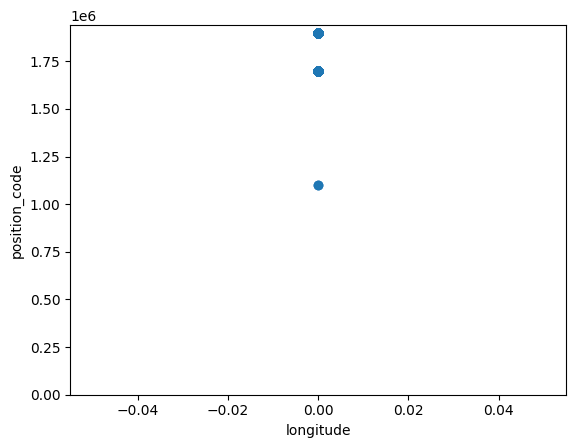

In [ ]:
sns.regplot(x='longitude', y="position_code", data=missing_position)
plt.ylim(0,)

In [ ]:
missing_position['position_code'].unique()

array([1700001, 1900006, 1900002, 1100004])

There is a strong relation between `position_code` and `longitude` as well as `latitude`, because these points all fall in `position_code` 1700001, 1900006, 1900002, and 1100004. Therefore, we can fill up the missing data in these two columns with average value of the subgroup of corresponding `position_code`.

In [ ]:
df_drop = df0.drop(missing_position.index)
for i, row in df0[df0['longitude'] == 0].iterrows():
  df0.loc[i, 'longitude'] = df_drop.loc[df_drop['position_code'] == df0.loc[i, 'position_code'], 'longitude'].mean()
  df0.loc[i, 'latitude'] = df_drop.loc[df_drop['position_code'] == df0.loc[i, 'position_code'], 'latitude'].mean()

In [ ]:
nan_longitude_rows = df0[df0['longitude'].isna()]
nan_longitude_rows[['longitude', 'latitude', 'position_code']]

longitude  latitude  position_code
53           NaN       NaN        1900006
256          NaN       NaN        1900006
301          NaN       NaN        1900006
306          NaN       NaN        1900006
326          NaN       NaN        1900006
...          ...       ...            ...
58555        NaN       NaN        1900006
58678        NaN       NaN        1900006
58997        NaN       NaN        1900006
59120        NaN       NaN        1900006
59135        NaN       NaN        1900006

[488 rows x 3 columns]

In [ ]:
nan_longitude_rows['position_code'].unique()

array([1900006])

This imputation method "fill up the missing data with average value of the subgroup of corresponding `position_code`" returns some `NaN` values. This is because there is `NaN` in the condition of `df_drop.loc[df_drop['position_code'] == df0.loc[i, 'position_code'], 'longitude']`. 
It reflects all records that is in region #19, district #06 have no longitude and latitude.

Therefore, for these records with `position_code` of 1900006 we impute them by average value of the subgroup with only the same `region_code`.

In [ ]:
for i, row in nan_longitude_rows.iterrows():
  df0.loc[i, 'longitude'] = df_drop.loc[df_drop['region_code'] == df0.loc[i, 'region_code'], 'longitude'].mean()
  df0.loc[i, 'latitude'] = df_drop.loc[df_drop['region_code'] == df0.loc[i, 'region_code'], 'latitude'].mean()

In [ ]:
nan_longitude_rows = df0[df0['longitude'].isna()]
nan_longitude_rows

Empty DataFrame
Columns: [status_group, date_recorded, gps_height, installer, longitude, latitude, basin, region_code, district_code, position_code, lga, ward, population, public_meeting, scheme_management, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group]
Index: []

In [ ]:
df0['longitude'].value_counts()

34.193137    1057
33.091564     488
33.333353     264
34.746760       3
38.180538       2
             ... 
35.885754       1
36.626541       1
37.333530       1
38.970078       1
38.104048       1
Name: longitude, Length: 57519, dtype: int64

In [ ]:
for pos_code in [1700001, 1900006, 1900002, 1100004]:
  print(df0.loc[df0['position_code'] == pos_code, 'longitude'].value_counts())

34.193137    1057
34.042373       1
34.275516       1
34.027670       1
34.143728       1
             ... 
34.415755       1
34.219360       1
34.273043       1
34.019274       1
34.122949       1
Name: longitude, Length: 195, dtype: int64
33.091564    488
Name: longitude, dtype: int64
33.333353    264
33.723235      1
33.142797      1
33.062151      1
33.562471      1
            ... 
33.560240      1
33.123440      1
33.392919      1
33.699503      1
33.428333      1
Name: longitude, Length: 476, dtype: int64
34.746760    3
34.642439    1
34.545024    1
34.589782    1
34.699937    1
            ..
35.173885    1
34.664787    1
34.669172    1
34.552574    1
35.249991    1
Name: longitude, Length: 2474, dtype: int64


Now we can say that all the `longitude` and `latitude` are properly imputed.

In [ ]:
df = df0

#### 2.4.3 `gps_height` - impute by average value of `gps_height` of 5 nearest waterpoints

In [ ]:
df0 = df.copy()

In [ ]:
df0[df0['gps_height'] == 0].shape[0] / df0.shape[0] * 100

34.40740740740741

In [ ]:
missing_gps_height = df0[df0['gps_height'] == 0]
df_drop = df0.drop(missing_gps_height.index)
df_drop['gps_height'].unique()

array([1390, 1399,  686, ...,  -90, 2091, 2366])

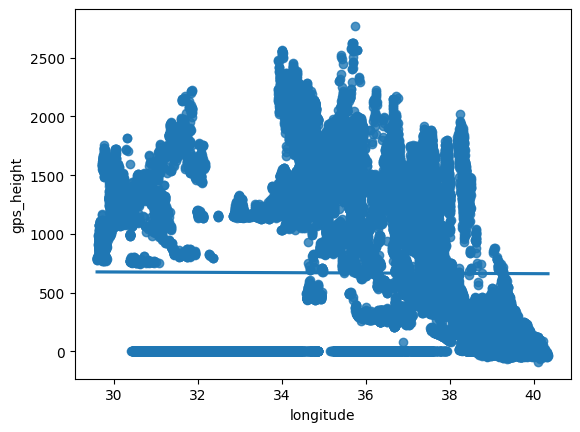

In [ ]:
sns.regplot(x='longitude', y="gps_height", data=df0)
plt.show()

From the calculation and regplot above, we found that there is too many missing data (34.41%) in `gps_height` and an uneven distribution bewteen `gps_height` and geographic location. Generally speaking, geographic locations that are close to each other differs small in `gps_height`, and therefore, a KNN regressor is used to generate the missing `gps_height` to fill into the missing records.

In [ ]:
df_knn = df_drop.copy()
df_lack = missing_gps_height.copy()

In [ ]:
train_set, test_set = train_test_split(df_knn, test_size=0.2, random_state=42)

In [ ]:
x_train = train_set[['latitude', 'longitude']].round(3).values
y_train = train_set['gps_height'].values
x_test = test_set[['latitude', 'longitude']].round(3).values
y_test = test_set['gps_height'].values
print(str(x_train.shape) + ' ' + str(y_train.shape) + ' ' + str(x_test.shape) + ' ' + str(y_test.shape))

(31169, 2) (31169,) (7793, 2) (7793,)


In [ ]:
knr = KNeighborsRegressor(n_neighbors = 5)
knr.fit(x_train, y_train)
# y_predict = knr.predict(x_test)
score = knr.score(x_test, y_test, sample_weight=None)
print('Accuracy = {}'.format(score))

Accuracy = 0.9961864303084409


We found that the accuracy of using `langitude` and `latitude` to predict `gps_height` is quite high. It states that the KNN regressor works fine in this dataset.

In [ ]:
x_predict = df_lack[['latitude','longitude']].values
y_predict = knr.predict(x_predict)
df_lack['gps_height'] = y_predict
df_lack

status_group date_recorded  gps_height   installer  longitude  latitude            basin  region_code  district_code  position_code              lga         ward  population public_meeting scheme_management permit  construction_year extraction_type extraction_type_group extraction_type_class        management management_group         payment payment_type water_quality quality_group      quantity quantity_group                source           source_type source_class              waterpoint_type waterpoint_type_group
4          functional    2011-07-13      1330.2     artisan  31.130847 -1.825359    Lake Victoria           18              1        1800001          Karagwe   nyakasimbi           0           True               NaN   True                  0         gravity               gravity               gravity             other            other       never pay    never pay          soft          good      seasonal       seasonal  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe
5          functional    2011-03-13        10.6         dwe  39.172796 -4.765587          Pangani            4              8         400008           Mkinga          moa           1           True               VWC   True               2009     submersible           submersible           submersible               vwc       user-group  pay per bucket   per bucket         salty         salty        enough         enough                 other                 other      unknown  communal standpipe multiple    communal standpipe
6      non functional    2012-10-01      1157.4        dwsp  33.362410 -3.766365         Internal           17              3        1700003  Shinyanga Rural       samuye           0           True               VWC   True                  0          swn 80                swn 80              handpump               vwc       user-group       never pay    never pay          soft          good        enough         enough           machine dbh              borehole  groundwater                    hand pump             hand pump
7      non functional    2012-10-09      1064.0         dwe  32.620617 -4.226198  Lake Tanganyika           17              3        1700003           Kahama       chambo           0           True               NaN   True                  0     nira/tanira           nira/tanira              handpump               wug       user-group         unknown      unknown         milky         milky        enough         enough          shallow well          shallow well  groundwater                    hand pump             hand pump
8      non functional    2012-11-03      1035.0    wateraid  32.711100 -5.146712  Lake Tanganyika           14              6        1400006     Tabora Urban     itetemia           0           True               VWC   True                  0   india mark ii         india mark ii              handpump               vwc       user-group       never pay    never pay         salty         salty      seasonal       seasonal           machine dbh              borehole  groundwater                    hand pump             hand pump
...               ...           ...         ...         ...        ...       ...              ...          ...            ...            ...              ...          ...         ...            ...               ...    ...                ...             ...                   ...                   ...               ...              ...             ...          ...           ...           ...           ...            ...                   ...                   ...          ...                          ...                   ...
59384  non functional    2011-07-10      1330.2     concern  30.667805 -2.483710    Lake Victoria           18             30        1800030            Ngara    nyamiyaga           0           True               VWC  False                  0         gravity               gravity             

In [ ]:
for i in range(df_lack.shape[0]):
  df0.loc[df_lack.index.values[i],'gps_height'] = df_lack.loc[df_lack.index.values[i],'gps_height']
df0.head()

status_group date_recorded  gps_height    installer  longitude   latitude                    basin  region_code  district_code  position_code        lga        ward  population public_meeting scheme_management permit  construction_year extraction_type extraction_type_group extraction_type_class management management_group         payment payment_type water_quality quality_group      quantity quantity_group                source           source_type source_class              waterpoint_type waterpoint_type_group
0      functional    2011-03-14      1390.0        roman  34.938093  -9.856322               Lake Nyasa           11              5        1100005     Ludewa    mundindi         109           True               VWC  False               1999         gravity               gravity               gravity        vwc       user-group    pay annually     annually          soft          good        enough         enough                spring                spring  groundwater           communal standpipe    communal standpipe
1      functional    2013-03-06      1399.0      grumeti  34.698766  -2.147466            Lake Victoria           20              2        2000002  Serengeti       natta         280            NaN             Other   True               2010         gravity               gravity               gravity        wug       user-group       never pay    never pay          soft          good  insufficient   insufficient  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe
2      functional    2013-02-25       686.0  worldvision  37.460664  -3.821329                  Pangani           21              4        2100004  Simanjiro     ngorika         250           True               VWC   True               2009         gravity               gravity               gravity        vwc       user-group  pay per bucket   per bucket          soft          good        enough         enough                   dam                   dam      surface  communal standpipe multiple    communal standpipe
3  non functional    2013-01-28       263.0       unicef  38.486161 -11.155298  Ruvuma / Southern Coast           90             63        9000063   Nanyumbu    nanyumbu          58           True               VWC   True               1986     submersible           submersible           submersible        vwc       user-group       never pay    never pay          soft          good           dry            dry           machine dbh              borehole  groundwater  communal standpipe multiple    communal standpipe
4      functional    2011-07-13      1330.2      artisan  31.130847  -1.825359            Lake Victoria           18              1        1800001    Karagwe  nyakasimbi           0           True               NaN   True                  0         gravity               gravity               gravity      other            other       never pay    never pay          soft          good      seasonal       seasonal  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe

In [ ]:
missing_gps_height = df0[df0['gps_height'].isna()]
missing_gps_height

Empty DataFrame
Columns: [status_group, date_recorded, gps_height, installer, longitude, latitude, basin, region_code, district_code, position_code, lga, ward, population, public_meeting, scheme_management, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group]
Index: []

We filled all the missing data in `gps_height`.

In [ ]:
df = df0

#### 2.4.4 `construction_year` - doing nothing

In [ ]:
df0 = df.copy()

In [ ]:
correlations = df.corr()['construction_year']
top_5_corr = correlations.nlargest(5)
top_5_corr

construction_year    1.000000
longitude            0.464149
population           0.260910
district_code        0.048315
position_code        0.031724
Name: construction_year, dtype: float64

In [ ]:
missing_construction_year = df0[df0['construction_year'] == 0]
print(missing_construction_year.shape)
print(len(missing_construction_year['installer'].unique()))
df_drop = df0.drop(missing_construction_year.index)
df_drop.shape

(20709, 33)
677


(38691, 33)

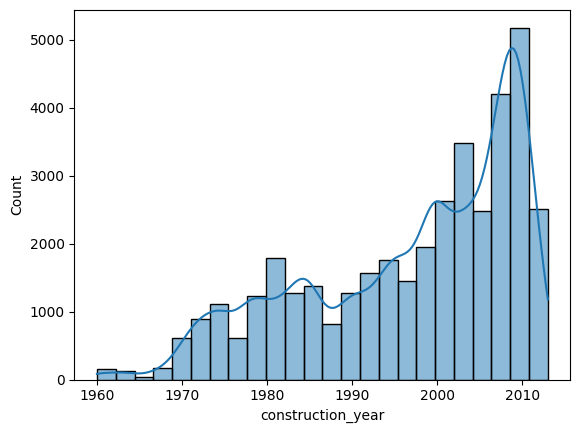

In [ ]:
sns.histplot(data=df_drop, x='construction_year', bins=24, kde=True)
plt.show()

Section 2.1.2 shows that 34.86% of the data does not have the construction year. In addition, we find that `construction_year` has weak correlation with all the other features (most significant correlation is 0.46), so we cannot use other features to impute the missing value in the `construction_year`. On the other hand, it's also a lot of data to simply drop. We will keep 0 values for now.

#### 2.4.5 `population` - doing nothing 

(0.0, 14908086.211418599)

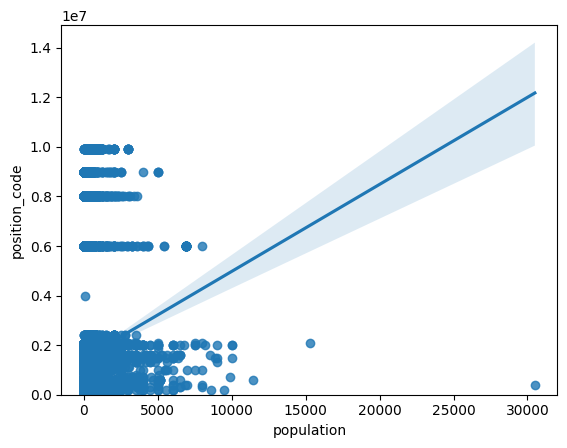

In [ ]:
sns.regplot(x='population', y="position_code", data=df)
plt.ylim(0,)

We found that the `population` presents continuous series among 0 - 5000 in the geographic location. It means that it is possible for the parameter `population` to be 0. Therefore, the values of 0 in `population` are not regarded as mising data and they are kept.

#### 2.4.6 `installer` - uniform [empty value], '0', 'nan' to 'unknown'

In [ ]:
for attr in ('installer', 'scheme_management'):
  print(attr.ljust(20) + '\'\': ' + str(df[df[attr] == ''].shape[0]).ljust(10) + '\'None\': ' + str(df[df[attr] == 'None'].shape[0]).ljust(10) + \
        '\'0\': ' + str(df[df[attr] == '0'].shape[0]).ljust(10) + '\'nan\': ' + str(df[df[attr] == 'nan'].shape[0]).ljust(10) + 'NaN: ' +  str(df[attr].isnull().sum()))

installer           '': 3         'None': 0         '0': 777       'nan': 3655      NaN: 0
scheme_management   '': 0         'None': 1         '0': 0         'nan': 0         NaN: 3877


The missing data in these categorical attributes varies in form. The missing data for attribute `installer` can be in the form of '' (empty), '0', or 'nan'. Therefore, we decide to uniform these missing data to 1 single category named 'unknown', indicating a missing installer.

In [ ]:
df0 = df.copy()

In [ ]:
len(df0['installer'].unique())

1852

In [ ]:
df0.loc[df0['installer'] == '', 'installer'] = 'unknown'
df0.loc[df0['installer'] == '0', 'installer'] = 'unknown'
df0.loc[df0['installer'] == 'nan', 'installer'] = 'unknown'

In [ ]:
len(df0['installer'].unique())

1849

In [ ]:
df = df0

#### 2.4.7 `scheme_management` - uniform 'Other', nan, 'None' to 'None'

In [ ]:
df0 = df.copy()

In [ ]:
df0['scheme_management'].unique()

array(['VWC', 'Other', nan, 'Private operator', 'WUG', 'Water Board',
       'WUA', 'Water authority', 'Company', 'Parastatal', 'Trust', 'SWC',
       'None'], dtype=object)

In [ ]:
df0['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

We can observe that the `scheme_management` only have 13 different categories and we suggest that 'Other', 'None' and NaN all represents that the management scheme of the waterpoint is other than all the schemes listed. Therefore, they can be uniformed to a single category 'Other'.

In [ ]:
df0.loc[df0['scheme_management'].isna(), 'scheme_management'] = 'Other'
df0.loc[df0['scheme_management'] == 'None', 'scheme_management'] = 'Other'

In [ ]:
df0['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Other                4644
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

After this process there are only 11 categories for `scheme_management`.

In [ ]:
df = df0

#### 2.4.8 `public_meeting`, `permit` - doing nothing

In [ ]:
df['public_meeting'].unique()

array([True, nan, False], dtype=object)

In [ ]:
df['permit'].unique()

array([False, True, nan], dtype=object)

For the `public_meeting` and `permit` both only have 3 different categories that are True, False, and NaN, these missing values are kept and are regarded as a saperate category.

### 2.5 Duplicates

In [ ]:
df0 = df.copy()
df0.shape

(59400, 33)

In [ ]:
df_d = df0[df0.duplicated()]
df_d

status_group date_recorded  gps_height    installer  longitude  latitude          basin  region_code  district_code  position_code      lga         ward  population public_meeting scheme_management permit  construction_year extraction_type extraction_type_group extraction_type_class management management_group    payment payment_type water_quality quality_group      quantity quantity_group        source   source_type source_class              waterpoint_type waterpoint_type_group
370        functional    2011-07-18      1249.6   government  33.091564 -2.620502  Lake Victoria           19              6        1900006    Geita  kalangalala           0           True               VWC   True                  0     submersible           submersible           submersible        vwc       user-group  never pay    never pay          soft          good  insufficient   insufficient   machine dbh      borehole  groundwater           communal standpipe    communal standpipe
1449       functional    2013-01-26      1336.0          dwe  34.193137 -2.964103  Lake Victoria           17              1        1700001  Bariadi       lugulu           0            NaN               WUG  False                  0     nira/tanira           nira/tanira              handpump        wug       user-group    unknown      unknown          soft          good        enough         enough  shallow well  shallow well  groundwater                    hand pump             hand pump
2634   non functional    2011-08-22      1249.6          dwe  33.091564 -2.620502  Lake Victoria           19              6        1900006    Geita       katoro           0           True               VWC   True                  0     submersible           submersible           submersible        vwc       user-group  never pay    never pay          soft          good  insufficient   insufficient   machine dbh      borehole  groundwater  communal standpipe multiple    communal standpipe
3415       functional    2013-02-16      1336.0          dwe  34.193137 -2.964103  Lake Victoria           17              1        1700001  Bariadi       mhango           0            NaN               WUG  False                  0     nira/tanira           nira/tanira              handpump        wug       user-group    unknown      unknown          soft          good        enough         enough  shallow well  shallow well  groundwater                    hand pump             hand pump
3622   non functional    2011-08-08      1249.6   government  33.091564 -2.620502  Lake Victoria           19              6        1900006    Geita     kharumwa           0           True               VWC   True                  0             ksb           submersible           submersible        vwc       user-group    unknown      unknown       unknown       unknown           dry            dry          lake    river/lake      surface  communal standpipe multiple    communal standpipe
...               ...           ...         ...          ...        ...       ...            ...          ...            ...            ...      ...          ...         ...            ...               ...    ...                ...             ...                   ...                   ...        ...              ...        ...          ...           ...           ...           ...            ...           ...           ...          ...                          ...                   ...
59158      functional    2011-07-19      1336.0          dwe  34.193137 -2.964103  Lake Victoria           17              1        1700001  Bariadi    chinamili           0           True               WUG  False                  0     nira/tanira           nira/tanira              handpump        wug       user-group  never pay    never pay          soft          good        enough         enough  shallow well  shallow well  groundwater                    hand pump             hand pump
59166      functional    2013-01-22      1336.0  worldvis

There are 601 rows of duplicate records. Drop these duplicate records.

In [ ]:
df0 = df0.drop_duplicates()
df0 = df0.reset_index().drop(['index'], axis=1)
print(df0.shape)
df = df0

(58799, 33)


### 2.6 Outliers

#### 2.6.1 Numerical attributes

In [ ]:
df0 = df.copy()

In [ ]:
df0.describe()

gps_height     longitude      latitude   region_code  district_code  position_code    population  construction_year
count  58799.000000  58799.000000  58799.000000  58799.000000   58799.000000   5.879900e+04  58799.000000       58799.000000
mean    1135.598105     35.122082     -5.822908     15.269818       5.658140   1.526987e+06    181.748890        1313.946785
std      586.884575      2.588407      2.814638     17.674708       9.675854   1.767477e+06    473.532888         947.295993
min      -90.000000     29.607122    -11.649440      1.000000       0.000000   1.000000e+05      0.000000           0.000000
25%      808.000000     33.287310     -8.572651      5.000000       2.000000   5.000030e+05      0.000000           0.000000
50%     1246.000000     34.938996     -5.067432     12.000000       3.000000   1.200004e+06     30.000000        1986.000000
75%     1468.000000     37.196893     -3.339936     17.000000       5.000000   1.700005e+06    220.000000        2004.000000
max     2770.000000     40.345193     -0.998464     99.000000      80.000000   9.900001e+06  30500.000000        2013.000000

As menthoned in Section 2.1.2 and 2.4.2, the `region_code`, `district_code` (and the combined `position_code`) are treat as Nominal data type, or label names. Therefore, there are no potential ontliers lying in these attributes. We would try to investigate for outliers in other numerical attributes by counting for values less than the 1st percentile and greater than 99th percentile.

In [ ]:
for attr in ['gps_height', 'longitude', 'latitude', 'population', 'construction_year']:
  len1 = df0[df0[attr] < df0[attr].quantile(0.01)].shape[0]
  len2 = df0[df0[attr] > df0[attr].quantile(0.99)].shape[0]
  print(attr + ' '  + str(len1) + ' ' + str(len2))

gps_height 565 37
longitude 588 588
latitude 588 588
population 0 482
construction_year 0 176


#### 2.6.2 `gps_height`, `longitude`, and `latitude` - doing nothing

In [ ]:
print('gps_height < 1%:\n' + str(df0.loc[df0['gps_height'] < df0['gps_height'].quantile(0.01), 'gps_height'].unique()))
print('gps_height > 99%:\n' + str(df0.loc[df0['gps_height'] > df0['gps_height'].quantile(0.99), 'gps_height'].unique()))
print('longitude < 1%:\n' + str(df0.loc[df0['longitude'] < df0['longitude'].quantile(0.01), 'longitude'].unique()))
print('longitude > 99%:\n' + str(df0.loc[df0['longitude'] > df0['longitude'].quantile(0.99), 'longitude'].unique()))
print('latitude < 1%:\n' + str(df0.loc[df0['latitude'] < df0['latitude'].quantile(0.01), 'latitude'].unique()))
print('latitude > 99%:\n' + str(df0.loc[df0['latitude'] > df0['latitude'].quantile(0.99), 'latitude'].unique()))

gps_height < 1%:
[-41. -25. -32. -40. -45. -24. -39. -33. -38. -37. -36. -30. -23. -34.
 -42. -29. -47. -27. -54. -28. -26. -43. -31. -44. -35. -48. -46. -51.
 -59. -63. -49. -50. -55. -53. -57. -52. -90.]
gps_height > 99%:
[2469. 2623. 2501. 2569. 2545. 2509. 2554. 2568. 2627. 2559. 2457. 2770.
 2626. 2560. 2484. 2552. 2536. 2464. 2628. 2506. 2585. 2557. 2576. 2535.
 2475. 2521. 2523. 2491. 2614. 2566. 2467. 2539. 2567.]
longitude < 1%:
[29.74706567 29.66972029 29.76800862 29.67098869 29.69182833 29.69282676
 29.64793205 29.64870608 29.68066628 29.7649775  29.67665482 29.68442893
 29.75057892 29.6388149  29.73974144 29.71335558 29.74147879 29.7470643
 29.70850769 29.69714186 29.73248038 29.73883172 29.72691205 29.6739145
 29.68274756 29.68347832 29.77480262 29.73195783 29.71241582 29.75552221
 29.73590984 29.66495335 29.74801149 29.74276245 29.64248841 29.65340571
 29.74738262 29.65029491 29.69695041 29.66941835 29.65885566 29.74380013
 29.75061904 29.76936188 29.65520863 29.67838125 

By observing the extreme values of `gps_height`, `longitude` and `latitude`, we can say that these values are reasonable because there are no values thats prominently larger or smaller than others, and they all complies with geographical truth of Tanzania (e.g. no `longitude` and `latitude` out of the country's land area). Therefore, no outliers are detected.

#### 2.6.3 `population` - doing nothing

In [ ]:
print('population > 99%:\n' + str(df0.loc[df0['population'] > df0['population'].quantile(0.99), 'population'].unique()))

population > 99%:
[ 2500  2530  2150  3226  2100  6922  5153  2353  2395  2200  3200  2800
  2013  4100  2300  2698  5030  4005  3500  3020  4500  4000  3127  3000
  7500  5000  6000  6500  4900  7000  3110  4210  2445  3981  2210  5500
  2130  3800  4523  2700  3600  2400  4550  5600  8000  2016  2129  4530
  3072  4600  5200  8600  2350  2385  3450  2560  9865  5016  9500  2620
  3832  5400  6300 15300  2813  2020  4230  4200  6800  2954  2780  8848
  2684  2630  3540  2314  5050  6330  2050  8500  3050  2514  6854  2652
  5300  3236  3982  4310  2450  2807  3014  3821  4800  2600 10000  4145
 30500  2670  3355  9000  2511  4520  3560  2198  2683  5550  4660  5560
  7530  3344  2310  2890  2416  2345  2531  2230  3241  3750  2685  2248
  3455  4788  2880  3411  2238  3568  2992  6302  2905  2518  3031 11463
  2250  3620  3850  3589  2750  2145  2461  2010  3250  2570  4208  8200
  2430  2569]


By observing the extreme values of `population`, we can find some values that are predominently larger than others. The largest value is 30500, which is 16851% from average population. However, such value might be possible that the ward around one waterpoint is large, and further investigation need to be made.

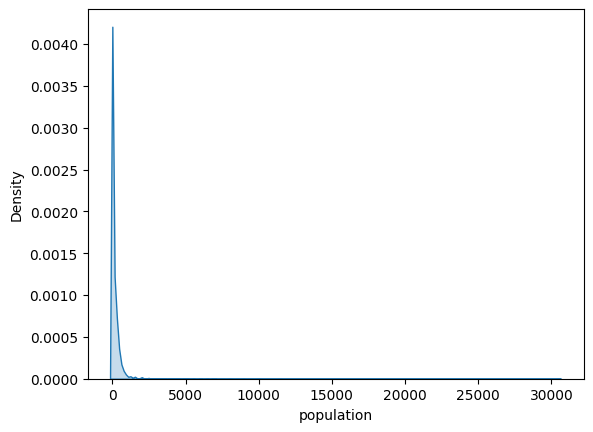

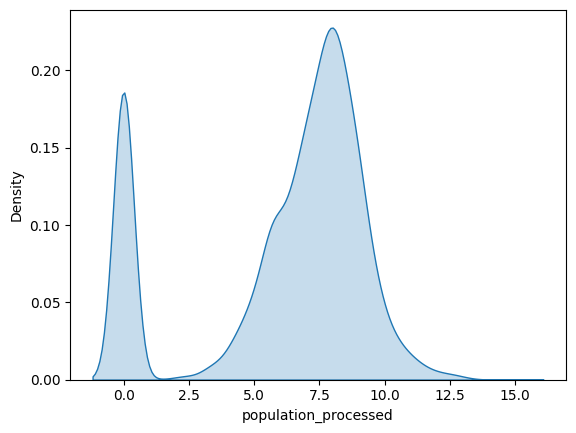

In [ ]:
sns.kdeplot(data=df0, x='population', fill=True)
plt.show()
df_temp = df0.copy()
df_temp.loc[df_temp['population'] == 0, 'population'] = np.nan
df_temp['population_processed'] = np.log2(df_temp['population'])
sns.kdeplot(data=df_temp, x='population_processed', fill=True)
plt.show()

Because it is difficult to observe the distribution of `population`, as shown in the first plot, a `log2()` algorithm is applied on `population` to generate `population_processed` where and another plot is generated. From the second plot we can see two highest peaks appear when `population_processed` is around 0 and 8 (actual `population` around $2^0=1$ and $2^8=256$). While the actual `population` is right-skewed, the loggeed population (`population_processed`) is generally symmetrical (has zero skew) around the two peaks, 0 and 8. This suggest that the `population` distribution can be accepted and there is no outliers.

#### 2.6.4 `construction_year` - doing nothing

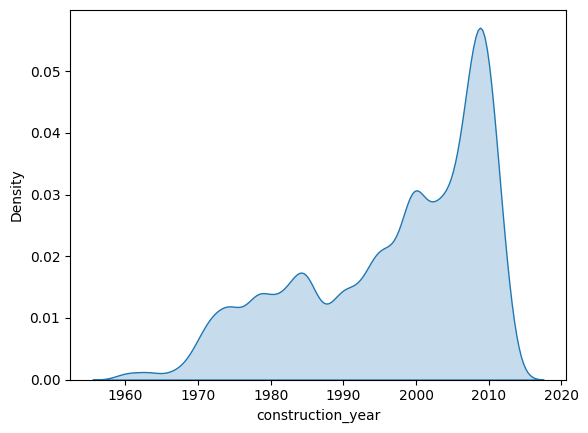

In [ ]:
df_temp = df0.copy()
df_temp.loc[df_temp['construction_year'] == 0, 'construction_year'] = np.nan
sns.kdeplot(data=df_temp, x='construction_year', fill=True)
plt.show()

The `construction_year` is left-skewed, with the peak around 2010. There is no extreme year that is prominently older or newer than other years. Therefore, there is no outliers in `construction_year`.

#### 2.6.5 Categorical attributes

These are all categorical attributes setting in the dataset. In general, outlier detection and treatment techniques are typically used for numerical data where the values have a clear order and magnitude. For categorical data, outliers may not have the same impact as in continuous variables, but there may still be situations where outlier values need to be addressed, such as if they are due to data entry errors or if they have a significant impact on downstream analyses. In this case, we decided to combine the processing of adjusting granularity and droping outliers.

In [ ]:
df0 = df.copy()

In [ ]:
df_cat = df0[['status_group', 'date_recorded', 'installer', 'basin', 'lga', 'ward',
     'public_meeting', 'scheme_management', 'permit', 'extraction_type',
     'extraction_type_group', 'extraction_type_class', 'management', 'management_group',
     'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
     'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type',
     'waterpoint_type_group']]
df_cat.describe()

status_group date_recorded installer          basin     lga   ward public_meeting scheme_management permit extraction_type extraction_type_group extraction_type_class management management_group    payment payment_type water_quality quality_group quantity quantity_group  source source_type source_class     waterpoint_type waterpoint_type_group
count         58799         58799     58799          58799   58799  58799          55619             58799  55743           58799                 58799                 58799      58799            58799      58799        58799         58799         58799    58799          58799   58799       58799        58799               58799                 58799
unique            3           356      1849              9     125   2090              2                11      2              18                    13                     7         12                5          7            7             8             6        5              5      10           7            3                   7                     6
top      functional    2011-03-15       dwe  Lake Victoria  Njombe  igosi           True               VWC   True         gravity               gravity               gravity        vwc       user-group  never pay    never pay          soft          good   enough         enough  spring      spring  groundwater  communal standpipe    communal standpipe
freq          31912           572     17052           9683    2503    307          50585             36534  38564           26749                 26749                 26749      40219            51897      25047        25047         50329         50329    32866          32866   17015       17015        45278               28476                 34495

These codes will query all the values that appear in each attribute and query the value with the lowest frequency.

In [ ]:
min_labels = df_cat.apply(lambda x: x.value_counts().idxmin())
min_labels

status_group               functional needs repair
date_recorded                           2011-09-09
installer                      gachumaconstruction
basin                                   Lake Rukwa
lga                                      Nyamagana
ward                                        mkumbi
public_meeting                               False
scheme_management                            Trust
permit                                       False
extraction_type          other - mkulima/shinyanga
extraction_type_group               india mark iii
extraction_type_class                 wind-powered
management                                   trust
management_group                           unknown
payment                                      other
payment_type                                 other
water_quality                   fluoride abandoned
quality_group                             fluoride
quantity                                   unknown
quantity_group                 

In [ ]:
min_label_counts = df_cat.apply(lambda x: x.value_counts().min())
min_label_counts.sort_values()

date_recorded                1
installer                    1
lga                          1
ward                         1
extraction_type              2
waterpoint_type_group        7
waterpoint_type              7
water_quality               17
source                      66
scheme_management           72
management                  78
extraction_type_group       97
extraction_type_class      117
quality_group              217
source_type                277
source_class               277
management_group           561
quantity                   788
quantity_group             788
payment                   1029
payment_type              1029
basin                     2454
status_group              4243
public_meeting            5034
permit                   17179
dtype: int64

Choose the last 10 minimum attributes and have a more detailed check.

In [ ]:
df_cat = df_cat[['date_recorded','installer','lga','ward','scheme_management',
                  'extraction_type','waterpoint_type_group','waterpoint_type',
                    'water_quality','source']]
df_cat.describe()

date_recorded installer     lga   ward scheme_management extraction_type waterpoint_type_group     waterpoint_type water_quality  source
count          58799     58799   58799  58799             58799           58799                 58799               58799         58799   58799
unique           356      1849     125   2090                11              18                     6                   7             8      10
top       2011-03-15       dwe  Njombe  igosi               VWC         gravity    communal standpipe  communal standpipe          soft  spring
freq             572     17052    2503    307             36534           26749                 34495               28476         50329   17015

#### 2.6.6 `date_recorded` - doing nothing

We found the all data in `date_recorded` is reasonable, ranging from 2002/10/14 to 2013/9/3. So it will be kept.

In [ ]:
df_cat['date_recorded'].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-11      1
2011-08-31      1
2011-09-21      1
2011-08-30      1
2013-12-01      1
Name: date_recorded, Length: 356, dtype: int64

In [ ]:
print(df_cat['date_recorded'].min())
print(df_cat['date_recorded'].max())

2002-10-14
2013-12-03


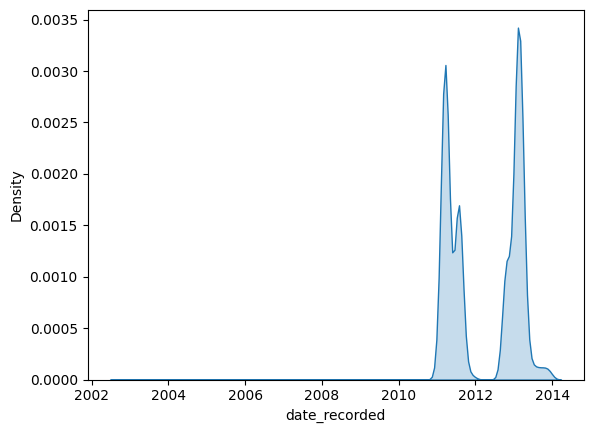

In [ ]:
df0["date_recorded"] = pd.to_datetime(df0["date_recorded"])
sns.kdeplot(data=df0, x='date_recorded', fill=True)
plt.show()

#### 2.6.7 `installer`, `lga`, `ward`, `scheme_management` (Specific name on location) - doing nothing

`installer`, `lga`, `ward`, `scheme_management` all has the single value. However, it is possible for these single data to exist, and not to be the type error. Thus, they will be kept.

In [ ]:
df_cat['installer'].value_counts()

dwe                 17052
unknown              4435
government           1808
hesawa               1388
rwe                  1189
                    ...  
teonaswambura           1
wateraidmajitech        1
husseinayubu            1
holand                  1
selepta                 1
Name: installer, Length: 1849, dtype: int64

In [ ]:
df_cat['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Rungwe          1106
Kilosa          1094
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [ ]:
df_cat['ward'].value_counts()

igosi       307
imalinyi    252
sihakati    232
mdandu      231
nduruma     217
           ... 
themi         1
sungwisi      1
ikweha        1
kapilula      1
kinungu       1
Name: ward, Length: 2090, dtype: int64

In [ ]:
df_cat['scheme_management'].value_counts()

VWC                 36534
WUG                  4901
Other                4615
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1672
Private operator     1063
Company              1061
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

`scheme_management`, `extraction_type`, `waterpoint_type_group`,`waterpoint_type`, `water_quality`, `source` have multiple correlation attributes. So we check every column in multiple correlation attributes to drop some duplicate ones, whose processes are mentioned in dimensionality reduction

### 2.7 Dimensionality reduction

#### 2.7.1 `extraction_type` + `extraction_type_group` + `extraction_type_class`

In [ ]:
df0 = df.copy()

In [ ]:
df0['extraction_type'].value_counts()

gravity                      26749
nira/tanira                   7866
other                         6367
submersible                   4723
swn 80                        3624
mono                          2844
india mark ii                 2377
afridev                       1727
ksb                           1376
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  97
cemo                            90
other - play pump               85
walimi                          43
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [ ]:
df0['extraction_type_group'].value_counts()

gravity            26749
nira/tanira         7866
other               6367
submersible         6099
swn 80              3624
mono                2844
india mark ii       2377
afridev             1727
rope pump            451
other handpump       359
other motorpump      122
wind-powered         117
india mark iii        97
Name: extraction_type_group, dtype: int64

In [ ]:
df0['extraction_type'].value_counts() - df0['extraction_type_group'].value_counts()

afridev                         0.0
cemo                            NaN
climax                          NaN
gravity                         0.0
india mark ii                   0.0
india mark iii                  0.0
ksb                             NaN
mono                            0.0
nira/tanira                     0.0
other                           0.0
other - mkulima/shinyanga       NaN
other - play pump               NaN
other - rope pump               NaN
other - swn 81                  NaN
other handpump                  NaN
other motorpump                 NaN
rope pump                       NaN
submersible                 -1376.0
swn 80                          0.0
walimi                          NaN
wind-powered                    NaN
windmill                        NaN
dtype: float64

In [ ]:
df0['extraction_type_class'].value_counts()

gravity         26749
handpump        16050
other            6367
submersible      6099
motorpump        2966
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [ ]:
df0['extraction_type'].value_counts() - df0['extraction_type_class'].value_counts()

afridev                         NaN
cemo                            NaN
climax                          NaN
gravity                         0.0
handpump                        NaN
india mark ii                   NaN
india mark iii                  NaN
ksb                             NaN
mono                            NaN
motorpump                       NaN
nira/tanira                     NaN
other                           0.0
other - mkulima/shinyanga       NaN
other - play pump               NaN
other - rope pump               NaN
other - swn 81                  NaN
rope pump                       NaN
submersible                 -1376.0
swn 80                          NaN
walimi                          NaN
wind-powered                    NaN
windmill                        NaN
dtype: float64

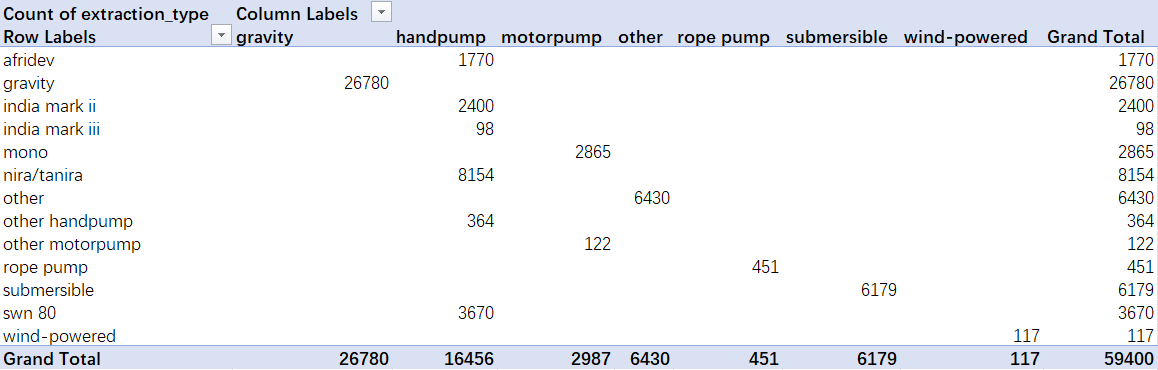

It shows the dependency among these attributes. For example, `handpump` have an inclusive relationship with a variety of pump brands. Their data is relatively scattered, and the variety is not particularly extensive. Therefore, we decided to keep the `extraction_type` only.

In [ ]:
df0 = df0.drop(columns=['extraction_type_class','extraction_type_group'])
df = df0

#### 2.7.2 `management` + `management_group`

In [ ]:
df0 = df.copy()

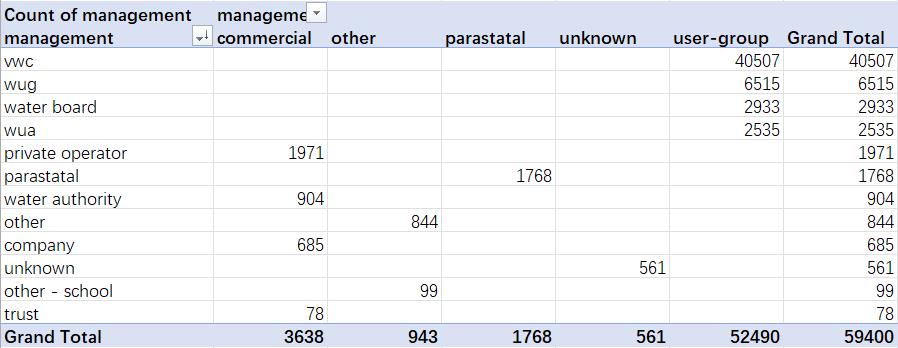

Because `management` has more scattered attribute and is divided in detail. So we keep `management` only.

In [ ]:
df0 = df0.drop(columns=['management_group'])
df = df0

#### 2.7.3 `payment` + `payment_type`

In [ ]:
df0 = df.copy()

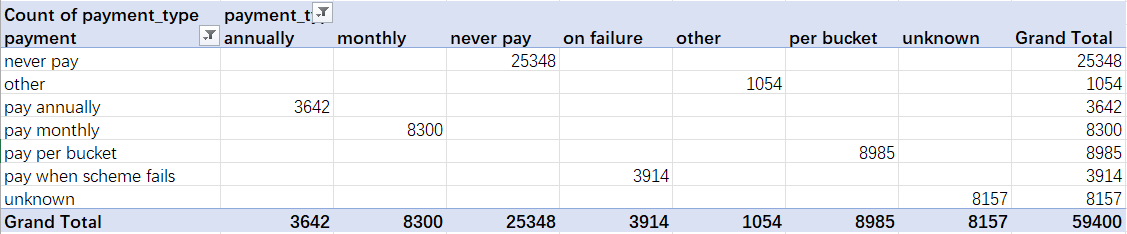

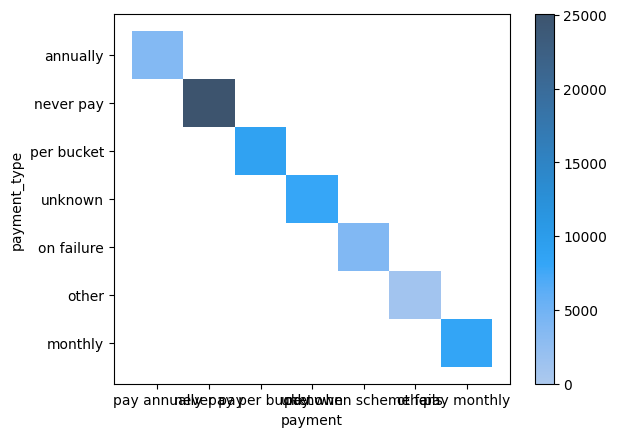

In [ ]:
sns.histplot(data=df0, x='payment', y='payment_type', cbar=True)
plt.show()

From the table, we can see that the feature is divided in `payment` and `payment_type`. but the results of the division are the same. So we decide to keep `payment` only.

In [ ]:
df0 = df0.drop(columns=['payment_type'])
df = df0

#### 2.7.4 `water_quality` + `quality_group`

In [ ]:
df0 = df.copy()

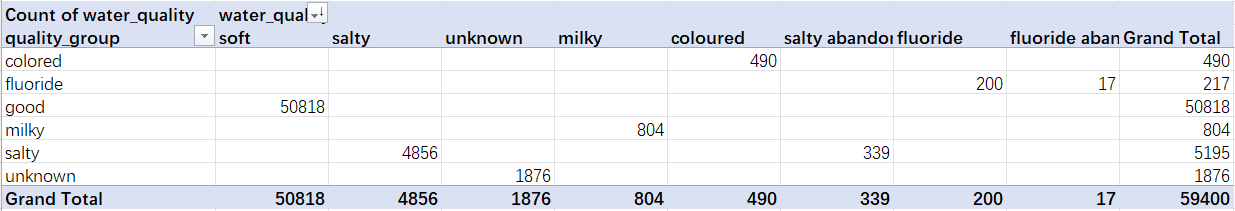

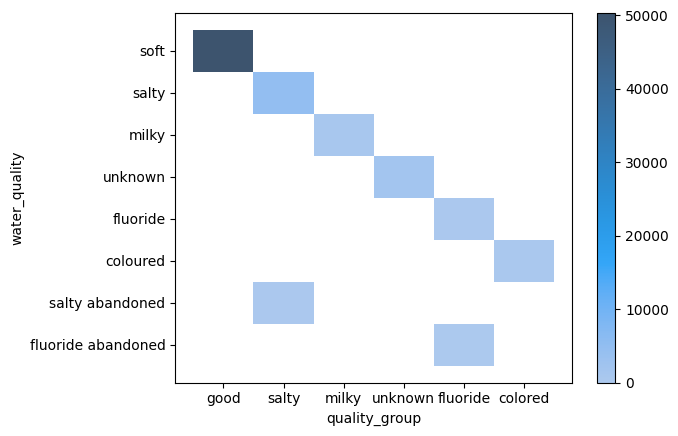

In [ ]:
sns.histplot(data=df0, x='quality_group', y='water_quality', cbar=True)
plt.show()

`water_quality` refined the `salty` into `salty` and `salty abandoned`, the `fluoride` as well. So we choose the `water_quality`.

In [ ]:
df0 = df0.drop(columns=['quality_group'])
df = df0

#### 2.7.5 `quantity` + `quantity_group`

In [ ]:
df0 = df.copy()

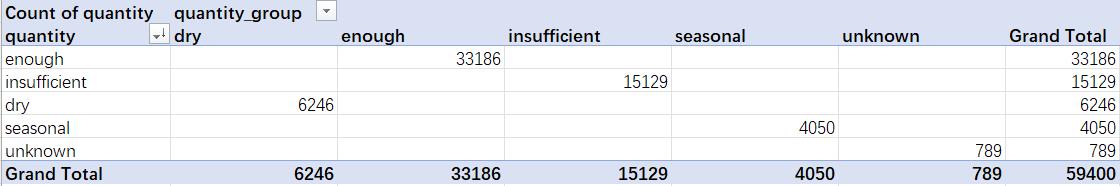

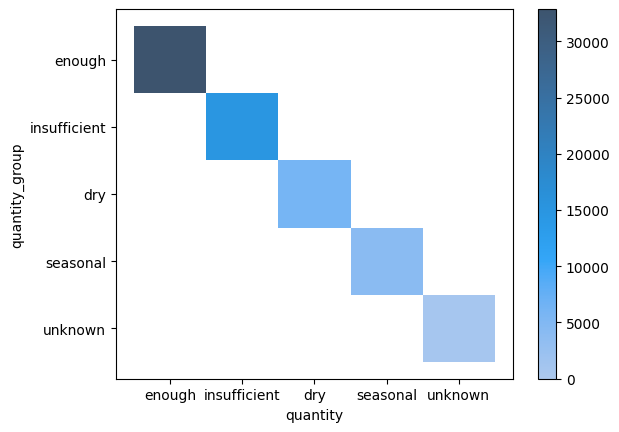

In [ ]:
sns.histplot(data=df0, x='quantity', y='quantity_group', cbar=True)
plt.show()

The column `quantity` and `quantity_group` are the same value. So we only keep `quantity`.

In [ ]:
df0 = df0.drop(columns=['quantity_group'])
df = df0

#### 2.7.6 `source` + `source_type` + `source_class`

In [ ]:
df0 = df.copy()

In [ ]:
df0['source'].value_counts()

spring                  17015
shallow well            16409
machine dbh             10980
river                    9612
rainwater harvesting     2289
hand dtw                  874
lake                      690
dam                       653
other                     211
unknown                    66
Name: source, dtype: int64

In [ ]:
df0['source_type'].value_counts()

spring                  17015
shallow well            16409
borehole                11854
river/lake              10302
rainwater harvesting     2289
dam                       653
other                     277
Name: source_type, dtype: int64

In [ ]:
df0['source_class'].value_counts()

groundwater    45278
surface        13244
unknown          277
Name: source_class, dtype: int64

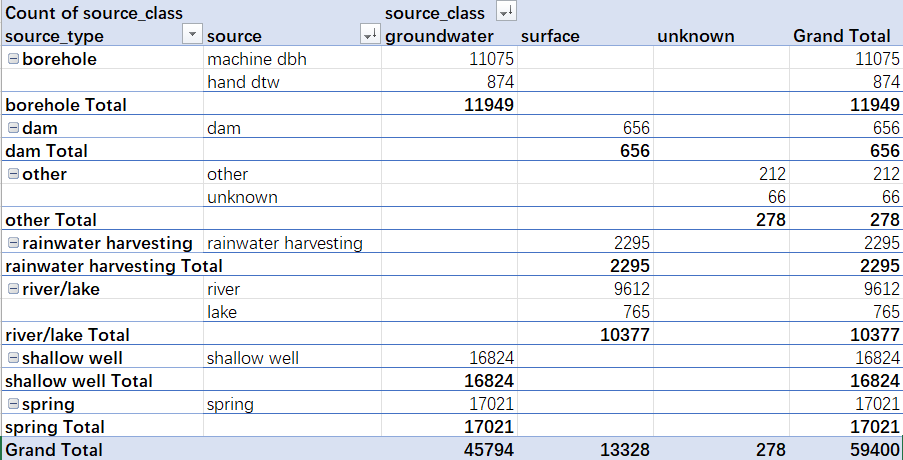

`source.unique()` $\subseteq$ `source_type.unique()` $\subseteq$ `source_class.unique()`.
So we keep `source` only.

In [ ]:
df0 = df0.drop(columns=['source_type','source_class'])
df = df0

#### 2.7.7 `waterpoint_type` + `waterpoint_type_group`

In [ ]:
df0 = df.copy()

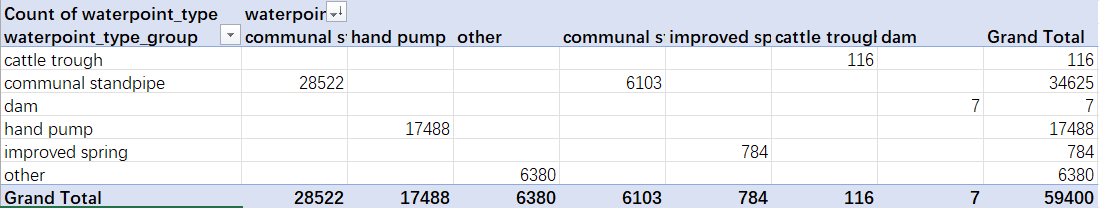

The column `waterpoint_type_group` and `waterpoint_type` are the same value. So we only keep `waterpoint_type`.

In [ ]:
df0 = df0.drop(columns=['waterpoint_type_group'])
df = df0

#### 2.7.8 Drop irrelavent attributes (after pre-processing)

Pre-processing for Raw Data is Done.

Start to modify dataset aiming to improve the performance of machine learning models.

In [ ]:
df_prep_done = df.copy()
df_prep_done.head()

status_group date_recorded  gps_height    installer  longitude   latitude                    basin  region_code  district_code  position_code        lga        ward  population public_meeting scheme_management permit  construction_year extraction_type management         payment water_quality      quantity                source              waterpoint_type
0      functional    2011-03-14      1390.0        roman  34.938093  -9.856322               Lake Nyasa           11              5        1100005     Ludewa    mundindi         109           True               VWC  False               1999         gravity        vwc    pay annually          soft        enough                spring           communal standpipe
1      functional    2013-03-06      1399.0      grumeti  34.698766  -2.147466            Lake Victoria           20              2        2000002  Serengeti       natta         280            NaN             Other   True               2010         gravity        wug       never pay          soft  insufficient  rainwater harvesting           communal standpipe
2      functional    2013-02-25       686.0  worldvision  37.460664  -3.821329                  Pangani           21              4        2100004  Simanjiro     ngorika         250           True               VWC   True               2009         gravity        vwc  pay per bucket          soft        enough                   dam  communal standpipe multiple
3  non functional    2013-01-28       263.0       unicef  38.486161 -11.155298  Ruvuma / Southern Coast           90             63        9000063   Nanyumbu    nanyumbu          58           True               VWC   True               1986     submersible        vwc       never pay          soft           dry           machine dbh  communal standpipe multiple
4      functional    2011-07-13      1330.2      artisan  31.130847  -1.825359            Lake Victoria           18              1        1800001    Karagwe  nyakasimbi           0           True             Other   True                  0         gravity      other       never pay          soft      seasonal  rainwater harvesting           communal standpipe

In [ ]:
df = df.drop(columns=['date_recorded','region_code','district_code','construction_year'])

In [ ]:
df.head()

status_group  gps_height    installer  longitude   latitude                    basin  position_code        lga        ward  population public_meeting scheme_management permit extraction_type management         payment water_quality      quantity                source              waterpoint_type
0      functional      1390.0        roman  34.938093  -9.856322               Lake Nyasa        1100005     Ludewa    mundindi         109           True               VWC  False         gravity        vwc    pay annually          soft        enough                spring           communal standpipe
1      functional      1399.0      grumeti  34.698766  -2.147466            Lake Victoria        2000002  Serengeti       natta         280            NaN             Other   True         gravity        wug       never pay          soft  insufficient  rainwater harvesting           communal standpipe
2      functional       686.0  worldvision  37.460664  -3.821329                  Pangani        2100004  Simanjiro     ngorika         250           True               VWC   True         gravity        vwc  pay per bucket          soft        enough                   dam  communal standpipe multiple
3  non functional       263.0       unicef  38.486161 -11.155298  Ruvuma / Southern Coast        9000063   Nanyumbu    nanyumbu          58           True               VWC   True     submersible        vwc       never pay          soft           dry           machine dbh  communal standpipe multiple
4      functional      1330.2      artisan  31.130847  -1.825359            Lake Victoria        1800001    Karagwe  nyakasimbi           0           True             Other   True         gravity      other       never pay          soft      seasonal  rainwater harvesting           communal standpipe

In [ ]:
df.shape

(58799, 20)

After pre-processing of the raw data, the dataset shape reduces from (59400, 41) to (58799, 20), with all missing values or outliers properly removed or imputed.

### 2.8 Save the cleaned dataset

In [ ]:
df.to_csv('/content/gdrive/MyDrive/cleaned_dataset.csv')

## 3. sub-RQ 1: How to best utilise geographical attributes of the waterpoint to improve prediction accuracy

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/cleaned_dataset.csv', index_col=0)
print(df.shape)
df.head()

(58799, 20)


status_group  gps_height    installer  longitude   latitude                    basin  position_code        lga        ward  population public_meeting scheme_management permit extraction_type management         payment water_quality      quantity                source              waterpoint_type
0      functional      1390.0        roman  34.938093  -9.856322               Lake Nyasa        1100005     Ludewa    mundindi         109           True               VWC  False         gravity        vwc    pay annually          soft        enough                spring           communal standpipe
1      functional      1399.0      grumeti  34.698766  -2.147466            Lake Victoria        2000002  Serengeti       natta         280            NaN             Other   True         gravity        wug       never pay          soft  insufficient  rainwater harvesting           communal standpipe
2      functional       686.0  worldvision  37.460664  -3.821329                  Pangani        2100004  Simanjiro     ngorika         250           True               VWC   True         gravity        vwc  pay per bucket          soft        enough                   dam  communal standpipe multiple
3  non functional       263.0       unicef  38.486161 -11.155298  Ruvuma / Southern Coast        9000063   Nanyumbu    nanyumbu          58           True               VWC   True     submersible        vwc       never pay          soft           dry           machine dbh  communal standpipe multiple
4      functional      1330.2      artisan  31.130847  -1.825359            Lake Victoria        1800001    Karagwe  nyakasimbi           0           True             Other   True         gravity      other       never pay          soft      seasonal  rainwater harvesting           communal standpipe

Geographical attributes for waterpoints include: `gps_height`, `longitude`, `latitude`, `basin`, `position_code`, `ward`. Within these, `gps_height`, `longitude`, `latitude` determines the exact location of the waterpoint in Coordinate System, `position_code`, `ward` provides information about its administrative allocation, and `basin` describes a nearby landform.

We would like to find the correlations among all of these attributes. However, there are some categorical attributes (`basin`, `position_code`, `ward`), which makes it impossible to simply calculate correlation coefficient between these attributes. Besides, the `longitude` and `latitude` of waterpoints should be treated in pair.

In [ ]:
df0 = df[['gps_height', 'longitude', 'latitude', 'basin', 'position_code', 'ward']]
df0

gps_height  longitude   latitude                    basin  position_code             ward
0          1390.0  34.938093  -9.856322               Lake Nyasa        1100005         mundindi
1          1399.0  34.698766  -2.147466            Lake Victoria        2000002            natta
2           686.0  37.460664  -3.821329                  Pangani        2100004          ngorika
3           263.0  38.486161 -11.155298  Ruvuma / Southern Coast        9000063         nanyumbu
4          1330.2  31.130847  -1.825359            Lake Victoria        1800001       nyakasimbi
...           ...        ...        ...                      ...            ...              ...
58794      1210.0  37.169807  -3.253847                  Pangani         300005  masamamagharibi
58795      1212.0  35.249991  -9.070629                   Rufiji        1100004           ikondo
58796      1067.8  34.017087  -8.750434                   Rufiji        1200007          chimala
58797       886.2  35.861315  -6.378573                   Rufiji         100004      mvumimakulu
58798       191.0  38.104048  -6.747464              Wami / Ruvu         500002       ngerengere

[58799 rows x 6 columns]

### 3.1 categorical attributes: `position_code`, `basin` and `ward`, and their correlations to `longitude` and `latitude`

 Firstly, we try to inspect all categorical attributes and their relationship with `longitude` and `latitude` of waterpoints by plotting them on the map.

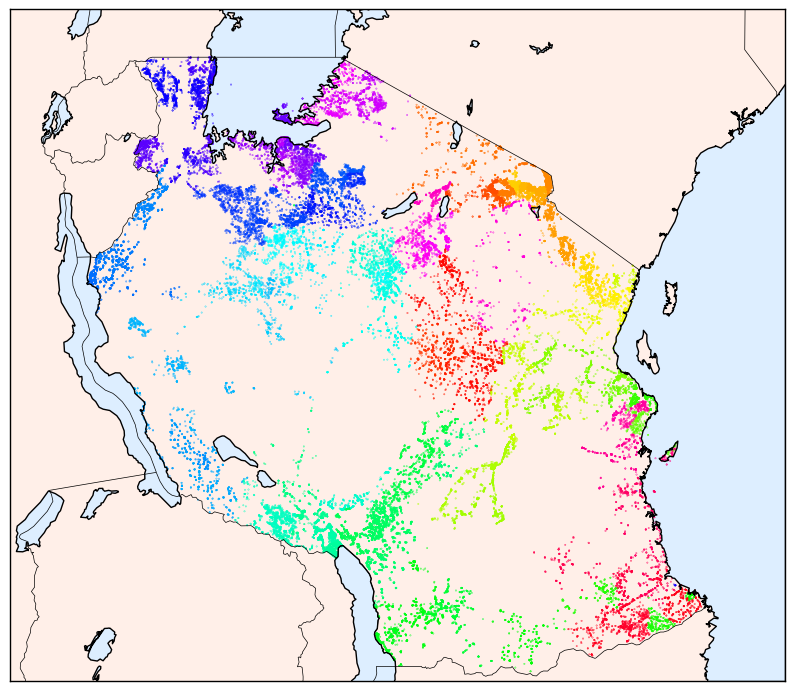

In [ ]:
x = df0['longitude']
y = df0['latitude']
c = df0['position_code']
le = LabelEncoder()
c = le.fit_transform(c)

plt.figure(figsize=(10,10))
m = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i')
m.fillcontinents(color="#FFEFE8", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()
m.scatter(x, y, s=0.3, marker = '.', latlon=True, c=c, cmap='hsv')
plt.show()

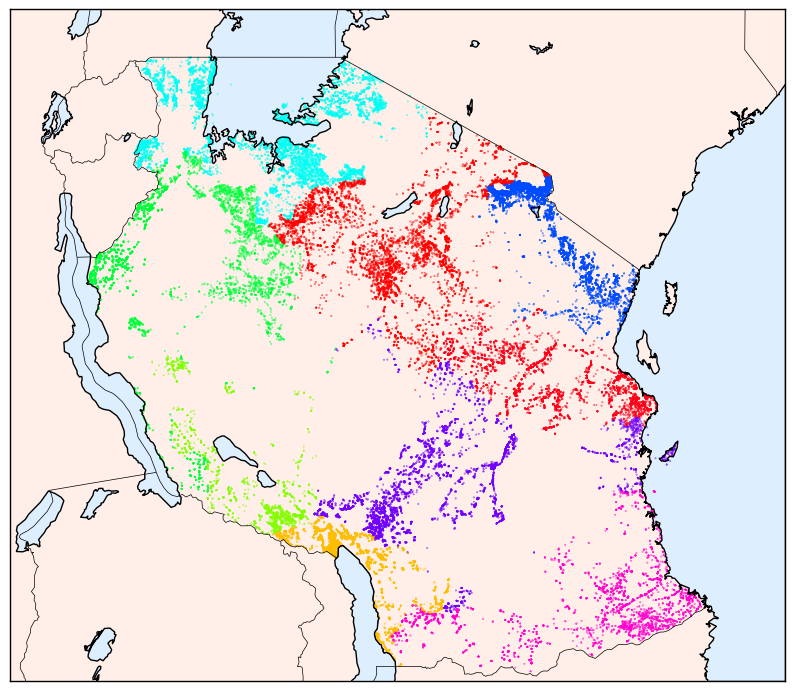

In [ ]:
x = df0['longitude']
y = df0['latitude']
c = df0['basin']
le = LabelEncoder()
c = le.fit_transform(c)

plt.figure(figsize=(10,10))
m = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i')
m.fillcontinents(color="#FFEFE8", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()
m.scatter(x, y, s=0.3, marker = '.', latlon=True, c=c, cmap='hsv')
plt.show()

We found the waterpoints overlap in some place, i.e. `position_code` and `basin` shares some similarity in their distribution. Therefore, a heatmap is drawn to further investigate there correlation.

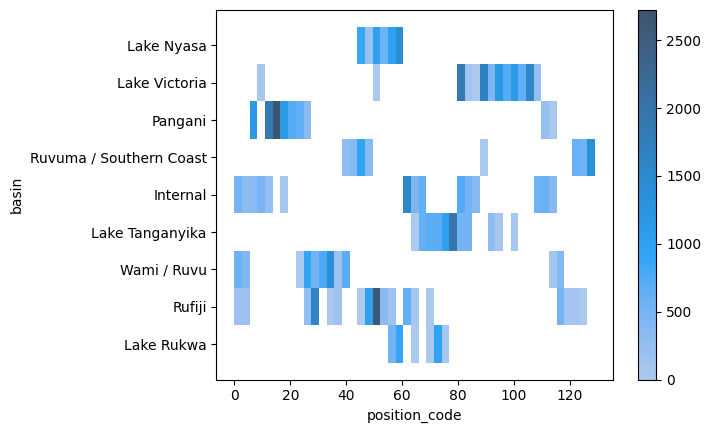

In [ ]:
df_hist = df0[['position_code', 'basin']]
le = LabelEncoder()
df_hist['position_code'] = le.fit_transform(df_hist['position_code'])
sns.histplot(data=df_hist, x='position_code', y='basin', cbar=True)
plt.show()

By observing the plots, we found that `position_code` and `basin` provide different classifications of the waterpoints (i.e. they are not 1-N mappings, 1 `basin` contains N `position_code` and one `position_code` is only in 1 `basin`). However, from the histplot above we may see that the waterpoints in each `position_code` always fall in 1-3 `basin`s. Therefore, there is a weak to medium relationship between `position_code` and `basin`, and they can both be used for prediction.


Now we continue to plot the `ward` on the map.

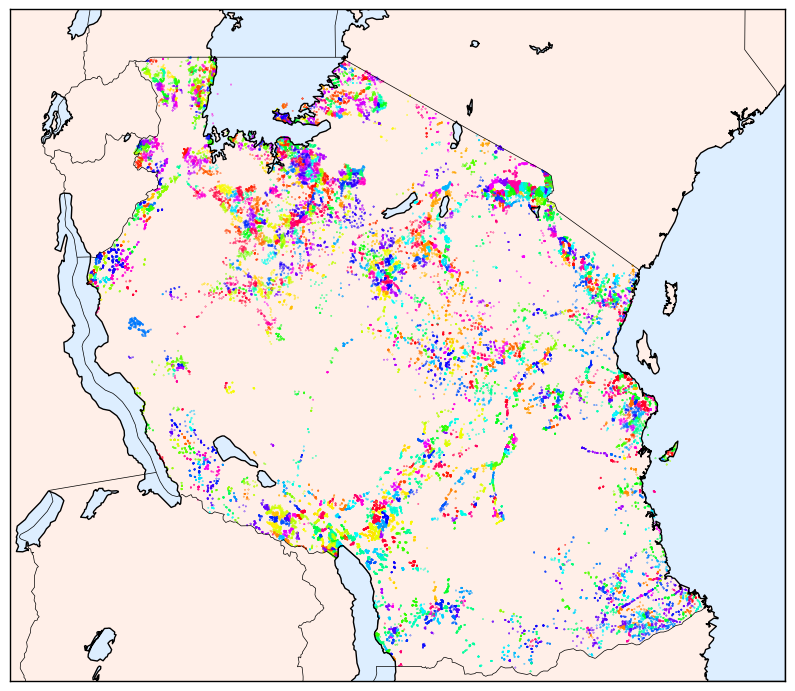

In [ ]:
x = df0['longitude']
y = df0['latitude']
c = df0['ward']
le = LabelEncoder()
c = le.fit_transform(c)

plt.figure(figsize=(10,10))
m = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i')
m.fillcontinents(color="#FFEFE8", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()
m.scatter(x, y, s=0.3, marker = '.', latlon=True, c=c, cmap='hsv')
plt.show()

From the plot, the granularity of `ward` is too fine, therefore providing no additional (useful) information other than simply using `longitude` and `latitude`. Therefore, the `ward` attribute is discarded.

In [ ]:
df0 = df0.drop('ward', axis=1)

### 3.2 Binned `gps_height` vs. `basin`?

Secondly, we would like to find the correlation between `longitude`, `latitude` and `gps_height` by plotting them on the map.



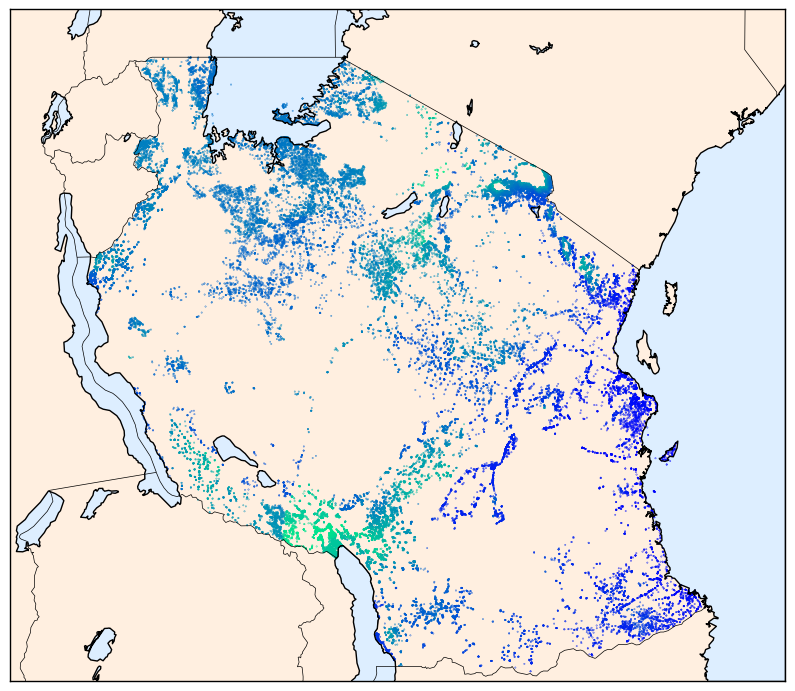

In [ ]:
x = df0['longitude']
y = df0['latitude']
c = df0['gps_height']

plt.figure(figsize=(10,10))
m = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i')
m.fillcontinents(color="#FFEFE0", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()
m.scatter(x, y, s=0.3, marker = '.', latlon=True, c=c, cmap='winter')
plt.show()

From the plot we can see that the change in `gps_height` is continuous. Generally speaking, the waterpoints on the eastern sea-shore are lowest, with the highest at the west-south side of the country.

We would like to measure the correlation between `gps_height` and `basin`, because it is generally believed that the difference in height of the terrain within the same geographical location (in this case, the same basin) should not be significant.

We first divide the `gps_height` into 9 bins (as the same number of basins) and plot them on the map, then we draw a boxplot on the height distribution in each basin.

In [ ]:
df0['gps_height_b'] = pd.qcut(df0['gps_height'], q=9)

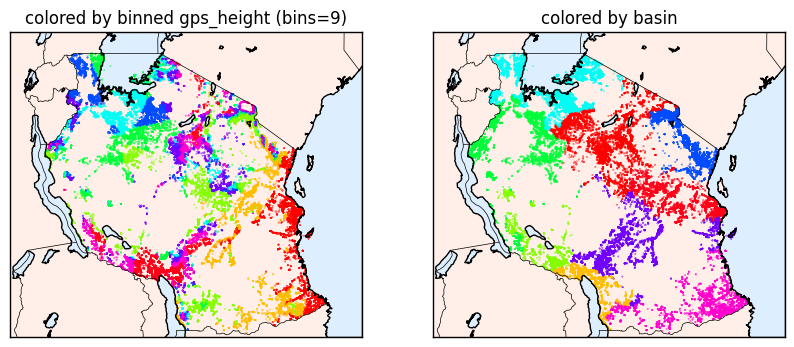

In [ ]:
x = df0['longitude']
y = df0['latitude']
c1 = df0['gps_height_b']
c2 = df0['basin']
le = LabelEncoder()
c1 = le.fit_transform(c1)
c2 = le.fit_transform(c2)

fig, axs = plt.subplots(1, 2, figsize=(10,10))
m = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i', ax=axs[0])
m.fillcontinents(color="#FFEFE8", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()
m.scatter(x, y, s=0.3, marker = '.', latlon=True, c=c1, cmap='hsv')
m2 = Basemap(projection='gnom', lon_0=35, lat_0=-6, width=1500000, height=1300000, resolution='i', ax=axs[1])
m2.fillcontinents(color="#FFEFE8", lake_color='#DDEEFF')
m2.drawmapboundary(fill_color="#DDEEFF")
m2.drawcoastlines()
m2.drawcountries()
m2.scatter(x, y, s=0.3, marker = '.', latlon=True, c=c2, cmap='hsv')
axs[0].title.set_text('colored by binned gps_height (bins=9)')
axs[1].title.set_text('colored by basin')
plt.show()

In [ ]:
df0 = df0.drop('gps_height_b', axis=1)

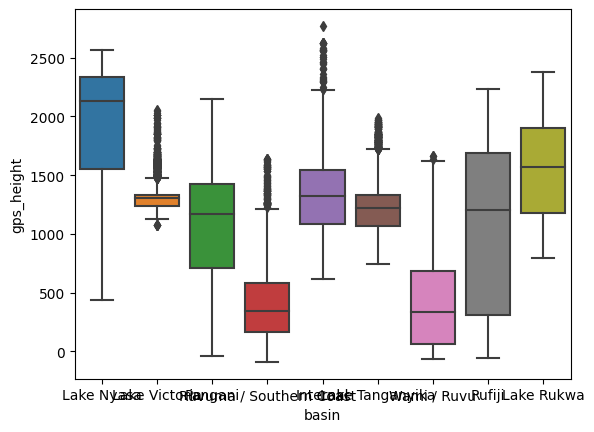

In [ ]:
sns.boxplot(data=df0, x='basin', y='gps_height')
plt.show()

From the plot we can see that height in each basin varies a lot. There is no correlation between `gps_height` and `basin`. Therefore, we cannot replace `basin` / `gps_height` by the other.

### 3.3 Feature importance: Recursive Feature Elimination (RFE)

From previous experiments we find all geographical attributes excluding `ward`, i.e. `gps_height`, `longitude`, `latitude`, `basin`, `position_code`, are useful and should be included into prediction of waterpoints. However,  `basin` and `position_code` are categorical attributes and once One-Hot Encoded, they greatly increases the number of features to 150+. It is argued that not all these attributes are of equal improtance.

We learned that RandomForestClassifier can provide an estimate of the improtance of each feature in the input data for making predictions. The following is a try.

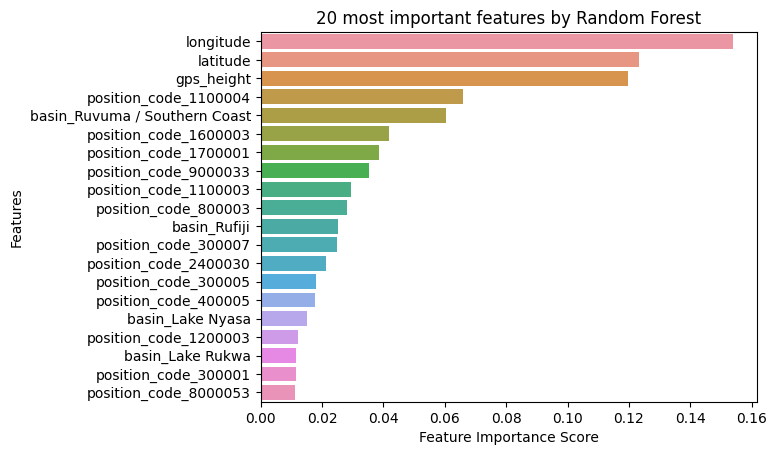

In [ ]:
y = df['status_group']
X = df0

X[["position_code"]] = X[["position_code"]].astype("object")
numerical_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
X = pd.concat([X.drop(categorical_cols, axis=1), encoded_cols], axis=1)
le = LabelEncoder()
y = le.fit_transform(y)

rf = RandomForestClassifier(n_estimators=100, max_depth=5, bootstrap=True, n_jobs=-1, random_state=42)
rf.fit(X, y)

feature_imp = pd.Series(rf.feature_importances_, index=X.columns.values).sort_values(ascending=False)

# print('Feature importances: ', rf.feature_importances_)
feature_imp_2 = feature_imp.nlargest(20)
sns.barplot(x=feature_imp_2, y=feature_imp_2.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('20 most important features by Random Forest')
plt.show()

We further learned that Recursive feature elimination can help better on deciding important features and eliminate non-important ones.

> "Recursive feature elimination is an example of backward feature elimination  in which we essentially first fit our model using all the features in a given set, then progressively one by one we remove the least significant features, each time re-fitting, until we are left with the desired number of features, which is set by the parameter n_features_to_select."

-- from https://www.kaggle.com/code/carlmcbrideellis/recursive-feature-elimination-rfe-example

Therefore, a RFE is applied to select the top 10 important geographical attributes.

In [ ]:
y = df['status_group']
X = df0

X[["position_code"]] = X[["position_code"]].astype("object")
numerical_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
X = pd.concat([X.drop(categorical_cols, axis=1), encoded_cols], axis=1)
le = LabelEncoder()
y = le.fit_transform(y)

rf = RandomForestClassifier(n_estimators=100, max_depth=5, bootstrap=True, n_jobs=-1, random_state=42)
rfe = RFE(rf, n_features_to_select=10)
rfe.fit(X, y)

features = X.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
  print(x, y)

1 gps_height
1 longitude
1 latitude
1 basin_Ruvuma / Southern Coast
1 position_code_300007
1 position_code_800003
1 position_code_1100003
1 position_code_1100004
1 position_code_1600003
1 position_code_1700001
2 basin_Lake Rukwa
3 position_code_9000033
4 position_code_300005
5 basin_Rufiji
6 position_code_2400030
7 position_code_400005
8 position_code_1200003
9 basin_Lake Nyasa
10 position_code_600001
11 basin_Pangani
12 basin_Wami / Ruvu
13 position_code_8000053
14 position_code_2000004
15 position_code_1600002
16 position_code_300001
17 position_code_8000023
18 position_code_1900004
19 position_code_1000002
20 position_code_1300002
21 position_code_1200001
22 position_code_2000006
23 position_code_1300003
24 position_code_8000013
25 position_code_1200006
26 basin_Lake Victoria
27 position_code_1100005
28 position_code_700002
29 position_code_1000005
30 position_code_1000003
31 position_code_1900002
32 position_code_1200007
33 position_code_1900001
34 position_code_1200004
35 position

The 10 kept features are: 
```
1 gps_height
1 longitude
1 latitude
1 basin_Ruvuma / Southern Coast
1 position_code_300007
1 position_code_800003
1 position_code_1100003
1 position_code_1100004
1 position_code_1600003
1 position_code_1700001
```

Any other features are discarded.

In [ ]:
df_drop1 = df.drop(['gps_height', 'longitude', 'latitude', 'basin', 'position_code', 'ward'], axis=1)

X = df0
X[["position_code"]] = X[["position_code"]].astype("object")
numerical_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
# scaler = StandardScaler()
# X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
X = pd.concat([X.drop(categorical_cols, axis=1), encoded_cols], axis=1)
df_drop2 = X[['gps_height', 'longitude', 'latitude', 'basin_Ruvuma / Southern Coast', 'position_code_300007', 'position_code_800003', 'position_code_1100003', 'position_code_1100004', 'position_code_1600003', 'position_code_1700001']]

In [ ]:
df0 = pd.concat([df_drop1, df_drop2], axis=1)
df0

status_group    installer             lga  population public_meeting scheme_management permit extraction_type   management                payment water_quality      quantity                source              waterpoint_type  gps_height  longitude  latitude  basin_Ruvuma / Southern Coast  position_code_300007  position_code_800003  position_code_1100003  position_code_1100004  position_code_1600003  position_code_1700001
0          functional        roman          Ludewa         109           True               VWC  False         gravity          vwc           pay annually          soft        enough                spring           communal standpipe    0.433482  -0.071083 -1.433026                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
1          functional      grumeti       Serengeti         280            NaN             Other   True         gravity          wug              never pay          soft  insufficient  rainwater harvesting           communal standpipe    0.448818  -0.163544  1.305842                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
2          functional  worldvision       Simanjiro         250           True               VWC   True         gravity          vwc         pay per bucket          soft        enough                   dam  communal standpipe multiple   -0.766082   0.903491  0.711138                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
3      non functional       unicef        Nanyumbu          58           True               VWC   True     submersible          vwc              never pay          soft           dry           machine dbh  communal standpipe multiple   -1.486844   1.299683 -1.894537                            1.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
4          functional      artisan         Karagwe           0           True             Other   True         gravity        other              never pay          soft      seasonal  rainwater harvesting           communal standpipe    0.331587  -1.541979  1.420283                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
...               ...          ...             ...         ...            ...               ...    ...             ...          ...                    ...           ...           ...                   ...                          ...         ...        ...       ...                            ...                   ...                   ...                    ...                    ...                    ...                    ...
58794      functional          ces             Hai         125           True       Water Board   True         gravity  water board         pay per bucket          soft        enough                spring           communal standpipe    0.126775   0.791121  0.912758                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
58795      functional         cefa          Njombe          56           True               VWC   True         gravity          vwc           pay annually          soft        enough                 river           communal standpipe    0.130183   0.049417 -1.153878                            0.0                   0.0                   0.0                    0.0                    1.0                    0.0                    0.0
58796      functional      unknown         Mbarali           0           True               VWC  False 

In [ ]:
df0.to_csv('/content/gdrive/MyDrive/cleaned_dataset_1.csv')

### 3.4 Conclusion

This sub research question discusses geographical attributes `gps_height`, `longitude`, `latitude`, `basin`, `position_code`, `ward` of the waterpoint. Firstly, the correlation is examined between features i) `longitude`, `latitude` vs. `position_code`, ii) `longitude`, `latitude` vs. `basin`, iii) `position_code` vs. `basin`, iv) `gps_height` vs. `basin`. It turns out that all the features have medium to weak correlations and thus cannot be elimilated. `ward` is removed because as a categorical data its granularity is too fine. Finally, RFE is done on one-hot coded features to select the top 10 important features.

## 4. sub-RQ 2: Is there any strong relationship between the datetime and the waterpoint functionality? How to best process the data in `recorded_data` and `construction_year` to improve the prediction accuracy.

### 4.1 Load the data

In [ ]:
# load data
df_label = pd.read_csv('/content/gdrive/MyDrive/training_set_labels.csv')
# print(df_label.shape)
df_value = pd.read_csv('/content/gdrive/MyDrive/training_set_values.csv')
# print(df_value.shape)
# print(df_value.head())
df = pd.merge(df_label, df_value, how='inner')
print(df.shape)
df.head()

(59400, 41)


id    status_group  amount_tsh date_recorded        funder  gps_height     installer  longitude   latitude              wpt_name  num_private                    basin  subvillage   region  region_code  district_code        lga        ward  population public_meeting              recorded_by scheme_management                  scheme_name permit  construction_year extraction_type extraction_type_group extraction_type_class management management_group         payment payment_type water_quality quality_group      quantity quantity_group                source           source_type source_class              waterpoint_type waterpoint_type_group
0  69572      functional      6000.0    2011-03-14         Roman        1390         Roman  34.938093  -9.856322                  none            0               Lake Nyasa    Mnyusi B   Iringa           11              5     Ludewa    Mundindi         109           True  GeoData Consultants Ltd               VWC                        Roman  False               1999         gravity               gravity               gravity        vwc       user-group    pay annually     annually          soft          good        enough         enough                spring                spring  groundwater           communal standpipe    communal standpipe
1   8776      functional         0.0    2013-03-06       Grumeti        1399       GRUMETI  34.698766  -2.147466              Zahanati            0            Lake Victoria     Nyamara     Mara           20              2  Serengeti       Natta         280            NaN  GeoData Consultants Ltd             Other                          NaN   True               2010         gravity               gravity               gravity        wug       user-group       never pay    never pay          soft          good  insufficient   insufficient  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe
2  34310      functional        25.0    2013-02-25  Lottery Club         686  World vision  37.460664  -3.821329           Kwa Mahundi            0                  Pangani     Majengo  Manyara           21              4  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd               VWC  Nyumba ya mungu pipe scheme   True               2009         gravity               gravity               gravity        vwc       user-group  pay per bucket   per bucket          soft          good        enough         enough                   dam                   dam      surface  communal standpipe multiple    communal standpipe
3  67743  non functional         0.0    2013-01-28        Unicef         263        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd               VWC                          NaN   True               1986     submersible           submersible           submersible        vwc       user-group       never pay    never pay          soft          good           dry            dry           machine dbh              borehole  groundwater  communal standpipe multiple    communal standpipe
4  19728      functional         0.0    2011-07-13   Action In A           0       Artisan  31.130847  -1.825359               Shuleni            0            Lake Victoria  Kyanyamisa   Kagera           18              1    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd               NaN                          NaN   True                  0         gravity               gravity               gravity      other            other       never pay    never pay          soft          good      seasonal       seasonal  rainwater harvesting  rainwater harvesting      surface           communal standpipe    communal standpipe

In [ ]:
df['status_group'], _ = pd.factorize(df['status_group'])
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df_q2 = df[['status_group','construction_year','date_recorded']]
df_q2.head()

status_group  construction_year date_recorded
0             0               1999    2011-03-14
1             0               2010    2013-03-06
2             0               2009    2013-02-25
3             1               1986    2013-01-28
4             0                  0    2011-07-13

### 4.2 Analyse data & Find correlation

In [ ]:
df_q2['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [ ]:
df_q2['date_recorded'].value_counts()

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-11      1
2011-08-31      1
2011-09-21      1
2011-08-30      1
2013-12-01      1
Name: date_recorded, Length: 356, dtype: int64

In [ ]:
df_drop0 = df[df['construction_year'] != 0]
correlations = df_drop0.corr()['construction_year']
correlations = correlations.drop('construction_year')
correlations = correlations.sort_values(ascending=False)
for feature, corr in correlations.items():
    print(f"{feature}: {corr}")

latitude: 0.03854662728948697
population: 0.03254357636734305
longitude: 0.028081734806134257
district_code: 0.007517588839955527
amount_tsh: 0.006331324278159668
num_private: -0.0032497337569350865
id: -0.004164829020332491
gps_height: -0.00624358904601975
region_code: -0.009755281015211148
status_group: -0.2409593588664473


Now we found the main problem inside is that there are excessive missing data in `construction_year`. Moreover, the 'construction_year' column has a low correlation with other columns in the DataFrame, which means it is less possible to be imputed by other existing data.

### 4.3 Examine the influence of data on prediction outcomes

In [ ]:
df_dateint = df.copy()
df_dateint['date_recorded'] = df_dateint['date_recorded'].astype(int)/ 10**18
df_drop0['date_recorded'] = df_dateint['date_recorded']
df_dateint['date_recorded']

0        1.300061
1        1.362528
2        1.361750
3        1.359331
4        1.310515
           ...   
59395    1.367539
59396    1.304726
59397    1.302480
59398    1.299542
59399    1.300838
Name: date_recorded, Length: 59400, dtype: float64

Retain the `construction_year` with 0

In [ ]:
df_dateint[['construction_year', 'status_group']].corr()

construction_year  status_group
construction_year           1.000000     -0.056893
status_group               -0.056893      1.000000

In [ ]:
df_dateint[['date_recorded', 'status_group']].corr()

date_recorded  status_group
date_recorded       1.000000      0.045972
status_group        0.045972      1.000000

Drop 0 values

In [ ]:
df_drop0[['construction_year', 'status_group']].corr()

construction_year  status_group
construction_year           1.000000     -0.240959
status_group               -0.240959      1.000000

In [ ]:
df_drop0[['date_recorded', 'status_group']].corr()

date_recorded  status_group
date_recorded       1.000000      0.083802
status_group        0.083802      1.000000

We found if the 0 values are dropped, the correlation will increase

### 4.4 Visualisation

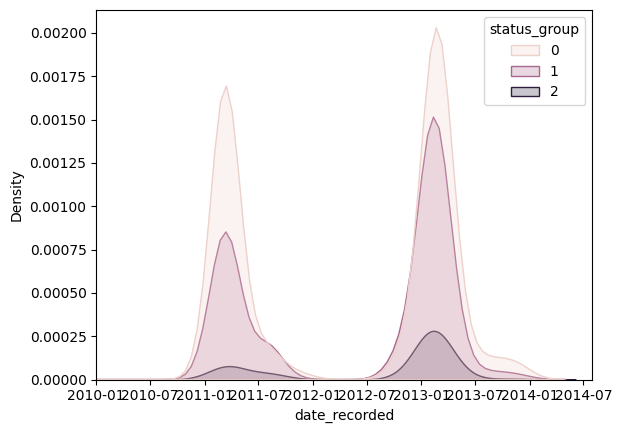

In [ ]:
df_drop0 = df[df['construction_year'] != 0]
sns.kdeplot(data=df_drop0, x='date_recorded', hue='status_group', fill=True)
start_date = pd.to_datetime('2010/01/01')
end_date = pd.to_datetime('2014/07/31')
plt.xlim([start_date, end_date])
plt.show()

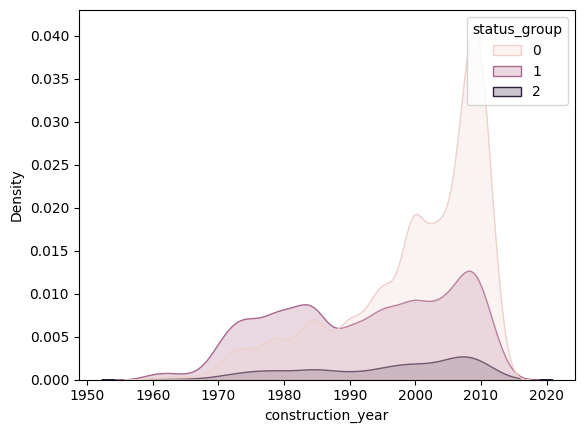

In [ ]:
sns.kdeplot(data=df_drop0, x='construction_year', hue='status_group', fill=True)
plt.show()

### 4.5 Conclusion

Our previous idea is to minus `construction_year` and `date_recorded` to calculate the `usage_year`. We thought these two original data has no separate meaning on the functionality of waterpoints which depends quite a lot on how long they are used. For example, both the correlation and the impact on the predict outcomes between `construction_year` and `date_recorded` are low. However, there are excessive missing data in `construction_year` and are impossible to impute by other attributes or use the only half dataset. Therefore, we considered they are unrelated attributes and decide to delete these two columns in the project.

## 5. Model development

### 5.1 RandomForest

#### 5.1.1 Data Preparation

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/cleaned_dataset_1.csv', index_col=0)
print(df.shape)
df.head()

(58799, 24)


status_group    installer        lga  population public_meeting scheme_management permit extraction_type management         payment water_quality      quantity                source              waterpoint_type  gps_height  longitude  latitude  basin_Ruvuma / Southern Coast  position_code_300007  position_code_800003  position_code_1100003  position_code_1100004  position_code_1600003  position_code_1700001
0      functional        roman     Ludewa         109           True               VWC  False         gravity        vwc    pay annually          soft        enough                spring           communal standpipe    0.433482  -0.071083 -1.433026                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
1      functional      grumeti  Serengeti         280            NaN             Other   True         gravity        wug       never pay          soft  insufficient  rainwater harvesting           communal standpipe    0.448818  -0.163544  1.305842                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
2      functional  worldvision  Simanjiro         250           True               VWC   True         gravity        vwc  pay per bucket          soft        enough                   dam  communal standpipe multiple   -0.766082   0.903491  0.711138                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
3  non functional       unicef   Nanyumbu          58           True               VWC   True     submersible        vwc       never pay          soft           dry           machine dbh  communal standpipe multiple   -1.486844   1.299683 -1.894537                            1.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
4      functional      artisan    Karagwe           0           True             Other   True         gravity      other       never pay          soft      seasonal  rainwater harvesting           communal standpipe    0.331587  -1.541979  1.420283                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_num = df[['population','gps_height','longitude','latitude']]
df_normalized = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

df_cate = df[['status_group','installer', 'lga', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']]
for column in df_cate.columns:
  df_cate[column] = pd.factorize(df_cate[column])[0]
df.update(df_normalized)
df.update(df_cate)

df.head()

status_group installer lga  population public_meeting scheme_management permit extraction_type management payment water_quality quantity source waterpoint_type  gps_height  longitude  latitude  basin_Ruvuma / Southern Coast  position_code_300007  position_code_800003  position_code_1100003  position_code_1100004  position_code_1600003  position_code_1700001
0            0         0   0    0.003574              0                 0      0               0          0       0             0        0      0               0    0.517483   0.496455  0.168353                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
1            0         1   1    0.009180             -1                 1      1               0          1       1             0        1      1               0    0.520629   0.474167  0.892122                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
2            0         2   2    0.008197              0                 0      1               0          0       2             0        0      2               1    0.271329   0.731374  0.734967                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
3            1         3   3    0.001902              0                 0      1               1          0       1             0        2      3               1    0.123427   0.826875  0.046394                            1.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
4            0         4   4    0.000000              0                 1      1               0          2       1             0        3      1               0    0.496573   0.141899  0.922364                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0

In [ ]:
Y = df['status_group'].copy().astype(int)
X = df.drop(columns = Y.name).copy()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(41159, 23) (17640, 23) (41159,) (17640,)


####  5.1.2 Create, fit, and evaluate model

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight(class_weight='balanced', y=Y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest model
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, Y_train, sample_weight = sample_weight)

# Predict the labels for the testing set
Y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model on the testing set
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.3f}")

target_names = ['functional', 'non functional', 'functional needs repair']
print(classification_report(Y_test, Y_pred, target_names=target_names))

Accuracy: 0.795
                         precision    recall  f1-score   support

             functional       0.80      0.87      0.84      9547
         non functional       0.83      0.77      0.80      6805
functional needs repair       0.50      0.34      0.41      1288

               accuracy                           0.80     17640
              macro avg       0.71      0.66      0.68     17640
           weighted avg       0.79      0.80      0.79     17640



### 2: Support Vector Machine (SVM) model

In [ ]:
from sklearn.svm import SVC
# Train a SVM model with default kernel
clf = SVC(kernel='rbf', C=0.1, gamma=1)
clf.fit(X_train, Y_train, sample_weight = sample_weight)

# Predict the labels for the testing set
Y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model on the testing set
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.3f}")

target_names = ['functional', 'non functional', 'functional needs repair']
print(classification_report(Y_test, Y_pred, target_names=target_names))

Accuracy: 0.636
                         precision    recall  f1-score   support

             functional       0.86      0.50      0.63      9547
         non functional       0.57      0.86      0.69      6805
functional needs repair       0.32      0.49      0.39      1288

               accuracy                           0.64     17640
              macro avg       0.59      0.61      0.57     17640
           weighted avg       0.71      0.64      0.64     17640



In [ ]:
from sklearn.svm import SVC
# Train a SVM model with default kernel
clf = SVC(kernel='rbf', C=0.1, gamma=0.001)
clf.fit(X_train, Y_train, sample_weight = sample_weight)

# Predict the labels for the testing set
Y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model on the testing set
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.3f}")

target_names = ['functional', 'non functional', 'functional needs repair']
print(classification_report(Y_test, Y_pred, target_names=target_names))

Accuracy: 0.456
                         precision    recall  f1-score   support

             functional       0.67      0.39      0.50      9547
         non functional       0.55      0.53      0.54      6805
functional needs repair       0.13      0.54      0.21      1288

               accuracy                           0.46     17640
              macro avg       0.45      0.49      0.41     17640
           weighted avg       0.58      0.46      0.49     17640



In [ ]:
from sklearn.svm import SVC
# Train a SVM model with default kernel
clf = SVC(kernel='rbf', C=10)
clf.fit(X_train, Y_train, sample_weight = sample_weight)

# Predict the labels for the testing set
Y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model on the testing set
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.3f}")

target_names = ['functional', 'non functional', 'functional needs repair']
print(classification_report(Y_test, Y_pred, target_names=target_names))

Accuracy: 0.472
                         precision    recall  f1-score   support

             functional       0.69      0.43      0.53      9547
         non functional       0.56      0.52      0.54      6805
functional needs repair       0.13      0.52      0.20      1288

               accuracy                           0.47     17640
              macro avg       0.46      0.49      0.42     17640
           weighted avg       0.60      0.47      0.51     17640



### 5.3 Multilayer Perceptron Classifier

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(10,10,10), (20,20,20), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=1000)

grid_search = GridSearchCV(mlp, param_grid, cv=5)

grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,200,100), activation='tanh', solver='adam', alpha=0.0001, learning_rate='adaptive', max_iter=1000)
mlp.fit(X_train, Y_train)
Y_pred = mlp.predict(X_test)

# Evaluate the accuracy of the model on the testing set
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.3f}")

target_names = ['functional', 'non functional', 'functional needs repair']
print(classification_report(Y_test, Y_pred, target_names=target_names))

### 5.4 kNN

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/cleaned_dataset_1.csv', index_col=0)
print(df.shape)
df.head()

(58799, 24)


status_group    installer        lga  population public_meeting scheme_management permit extraction_type management         payment water_quality      quantity                source              waterpoint_type  gps_height  longitude  latitude  basin_Ruvuma / Southern Coast  position_code_300007  position_code_800003  position_code_1100003  position_code_1100004  position_code_1600003  position_code_1700001
0      functional        roman     Ludewa         109           True               VWC  False         gravity        vwc    pay annually          soft        enough                spring           communal standpipe    0.433482  -0.071083 -1.433026                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
1      functional      grumeti  Serengeti         280            NaN             Other   True         gravity        wug       never pay          soft  insufficient  rainwater harvesting           communal standpipe    0.448818  -0.163544  1.305842                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
2      functional  worldvision  Simanjiro         250           True               VWC   True         gravity        vwc  pay per bucket          soft        enough                   dam  communal standpipe multiple   -0.766082   0.903491  0.711138                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
3  non functional       unicef   Nanyumbu          58           True               VWC   True     submersible        vwc       never pay          soft           dry           machine dbh  communal standpipe multiple   -1.486844   1.299683 -1.894537                            1.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0
4      functional      artisan    Karagwe           0           True             Other   True         gravity      other       never pay          soft      seasonal  rainwater harvesting           communal standpipe    0.331587  -1.541979  1.420283                            0.0                   0.0                   0.0                    0.0                    0.0                    0.0                    0.0

In [ ]:
# Split data into features and labels
X = df.drop('status_group', axis=1)
y = df['status_group']

# Impute NaN, True, False
mask = X.applymap(type) != bool
d = {True: 'TRUE', False: 'FALSE'}
X = X.where(mask, X.replace(d))
for attr in ['public_meeting', 'permit']:
  X[attr].fillna('None', inplace=True)

# Select subset of attributes
attributes = ['gps_height', 'longitude', 'latitude', 'population', 'public_meeting', \
              'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', \
              'basin_Ruvuma / Southern Coast', 'position_code_300007', 'position_code_800003', 'position_code_1100003', \
              'position_code_1100004', 'position_code_1600003', 'position_code_1700001']
X = X[attributes]

# Normalize features
numerical_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Normalize numerical attributes
scaler = StandardScaler() # MinMaxScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Normalize categorical attributes using one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

X = pd.concat([X.drop(categorical_cols, axis=1), encoded_cols], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

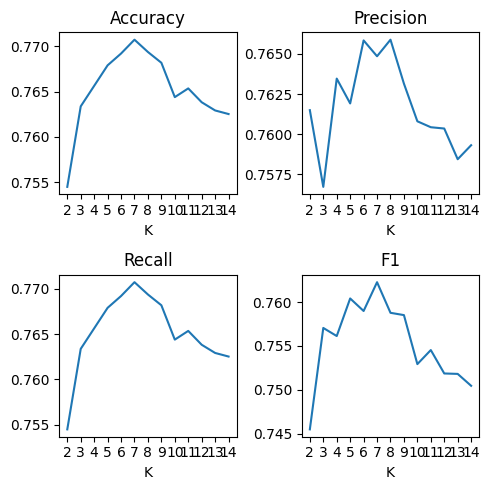

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define range of K values to try
k_values = range(2, 15)

# Initialize arrays to store evaluation metrics
accuracy = np.zeros(len(k_values))
precision = np.zeros(len(k_values))
recall = np.zeros(len(k_values))
f1 = np.zeros(len(k_values))
# conf_matrices = []

# Perform KNN classification for each value of K
for i, k in enumerate(k_values):
    # Fit KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = knn.predict(X_test)
    
    # Compute evaluation metrics
    accuracy[i] = accuracy_score(y_test, y_pred)
    precision[i] = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall[i] = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1[i] = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    # conf_matrices.append(confusion_matrix(y_test, y_pred, labels=[0,1,2]))
    
# Plot evaluation metrics as a function of K
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

axs[0,0].plot(k_values, accuracy)
axs[0,0].set_title('Accuracy')

axs[0,1].plot(k_values, precision)
axs[0,1].set_title('Precision')

axs[1,0].plot(k_values, recall)
axs[1,0].set_title('Recall')

axs[1,1].plot(k_values, f1)
axs[1,1].set_title('F1')

for ax in axs.flat:
    ax.set_xlabel('K')
    ax.set_xticks(k_values)

# Plot confusion matrices
# fig, axs = plt.subplots(1, len(k_values), figsize=(15, 3))
# axis_labels = ['f', 'fnr', 'nf']
# for i, conf_matrix in enumerate(conf_matrices):
#     sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axs[i], cbar=False, square=True, xticklabels=axis_labels, yticklabels=axis_labels)
#     axs[i].set_xlabel('Predicted')
#     axs[i].set_ylabel('Actual')
#     axs[i].set_title(f'K={k_values[i]}')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Fit KNN classifier
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train, y_train)

# Make predictions on test set
y_pred = knn.predict(X_test)

# Compute evaluation metrics
target_names = ['functional', 'functional needs repair', 'non functional']
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

             functional       0.77      0.88      0.82      9547
functional needs repair       0.53      0.30      0.38      1288
         non functional       0.80      0.71      0.75      6805

               accuracy                           0.77     17640
              macro avg       0.70      0.63      0.65     17640
           weighted avg       0.76      0.77      0.76     17640



### 5.5 Gradient Boosting Machine

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Fit the classifier
knn = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, random_state=42)
knn.fit(X_train, y_train)

# Make predictions on test set
y_pred = knn.predict(X_test)

# Compute evaluation metrics
target_names = ['functional', 'functional needs repair', 'non functional']
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

             functional       0.76      0.90      0.82      9547
functional needs repair       0.58      0.21      0.31      1288
         non functional       0.83      0.70      0.76      6805

               accuracy                           0.77     17640
              macro avg       0.72      0.60      0.63     17640
           weighted avg       0.77      0.77      0.76     17640



### 5.6 AdaBoost

In [ ]:
# # Split data into features and labels
# X = df.drop('status_group', axis=1)
# y = df['status_group']

# # Impute NaN, True, False
# mask = X.applymap(type) != bool
# d = {True: 'TRUE', False: 'FALSE'}
# X = X.where(mask, X.replace(d))
# for attr in ['public_meeting', 'permit']:
#   X[attr].fillna('None', inplace=True)

# # Select subset of attributes
# attributes = ['gps_height', 'longitude', 'latitude', 'population', 'public_meeting', \
#               'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type', \
#               'basin_Ruvuma / Southern Coast', 'position_code_300007', 'position_code_800003', 'position_code_1100003', \
#               'position_code_1100004', 'position_code_1600003', 'position_code_1700001']
# X = X[attributes]

# # Normalize features
# numerical_cols = X.select_dtypes(include=['float', 'int']).columns
# categorical_cols = X.select_dtypes(include=['object']).columns

# # Normalize numerical attributes
# scaler = StandardScaler() # MinMaxScaler()
# X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# # Normalize categorical attributes using one-hot encoding
# encoder = OneHotEncoder(sparse=False)
# encoded_cols = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
# encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)

# # Encode labels
# le = LabelEncoder()
# y = le.fit_transform(y)

# X = pd.concat([X.drop(categorical_cols, axis=1), encoded_cols], axis=1)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# over-sampling

# X = X_train
# y = y_train

# print("Before resampling:", sum(y == 0), sum(y == 1), sum(y == 2))

# X_resampled_1, y_resampled_1 = resample(X[y==1], y[y==1], n_samples=X[y==0].shape[0], random_state=42)
# X_resampled_2, y_resampled_2 = resample(X[y==2], y[y==2], n_samples=X[y==0].shape[0], random_state=42)
# X_balanced = pd.concat([X[y==0], X_resampled_1, X_resampled_2])
# y_balanced = pd.concat([pd.Series(y[y==0]), pd.Series(y_resampled_1), pd.Series(y_resampled_2)])
# print("After resampling:", sum(y_balanced == 0), sum(y_balanced == 1), sum(y_balanced == 2))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# Fit the classifier
knn = AdaBoostClassifier(n_estimators=1000, learning_rate=1.0, random_state=42)
# knn.fit(X_balanced, y_balanced)
knn.fit(X_train, y_train)

# Make predictions on test set
y_pred = knn.predict(X_test)

# Compute evaluation metrics
target_names = ['functional', 'functional needs repair', 'non functional']
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

             functional       0.71      0.88      0.79      9547
functional needs repair       0.44      0.10      0.16      1288
         non functional       0.78      0.63      0.70      6805

               accuracy                           0.73     17640
              macro avg       0.64      0.54      0.55     17640
           weighted avg       0.72      0.73      0.71     17640



## Appendix 1: Contribution

The table below shows the contributions of two of us to respective parts of the project. For each section, the one who was primarily responsible for writing the code for that part is marked with a 'Y'. Generally, two of us contributes equally in the project.

For each section we discussed ideas intensively before coding, so two of us contributed equally in terms of ideas. In terms of coding, generally, two of us contributed equally.

| Section | Subsections | Yuhao | Yichen |
|--|--|--|--|
|2.1||Y||
|2.2||Y||
|2.3||Y||
|2.4|2.4.1, 2.4.6 - 2.4.8|Y||
||2.4.2 - 2.4.5||Y|
|2.5||Y||
|2.6|2.6.1 - 2.6.4|Y||
||2.6.5 - 2.6.7||Y|
|2.7|||Y|
|3||Y||
|4|||Y|
|5.1-5.3|||Y|
|5.4-5.6||Y||